# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Project Goals

### Project statement
*For the locations in which Kiva has active loans, your objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.*

When we took a look at this prompt for the first time, we weren't really sure how we could go about predicting the welfare need of particular borrowers. Since we wanted to take a much more Machine Learning heavy approach for our solution (since this is for a Machine Learning class after all), we didn't really feel it would be all that impressive to create a model to predict one of the many poverty metrics created by experts in the field. We could have gone another route and attempted to create our own poverty metric, however we are no experts in the area, so even if we wcould create a good model, we wouldn't be able to know whether or not our metric is useful. So then we decided to take a look at the provided data, and try to see if there was something somewhat tangential to this main goal, and we came up with the idea of extracting a Perceived Poverty Index, which in theory could be very useful to Kiva. If we discover that this PPI correlates highly to actual poverty indexes, then Kiva would know that their lenders are fairly good at figuring out who needs to money most. If they do not correlate very much, then Kiva would know that lenders are not funding the loans in more impoverished locations, which could then be acted upon in order to try and balance the lending landscape.

Throughout this project, we hope to figure out just what goes into this PPI, create a model to predict it from information that can be aquired at the time the loan is posted on Kiva, and come up with a few specific use cases for this model depending on the actual outcomes of the model.

# Getting Data

For this project, since we wanted to create a model that would predict this PPI based on information that is readily available at the time which the loan is posted, we didn't want to bring in too much external data, since it might complicate running this system in real time.

The datasets we will be using are obviously the four datasets posted by Kiva for the project, as well as two datasets from [OPHI](https://www.kaggle.com/ophi/mpi) that give us more information regarding regional and national MPI metrics. Here MPI is the Multidimensional Poverty Index, which I have seen and heard everywhere, and seems to be the most popular metric for poverty that is out there.

With that, let's get this thing started

# Datasets

Rather than loading these one at a time as we need them, let's just load them all in at once, and use them when we need them.

In [2]:
# Kiva data
kiva_loans_o = pd.read_csv('kiva-data/kiva_loans.csv')
kiva_mpi_region_locations_o = pd.read_csv('kiva-data/kiva_mpi_region_locations.csv')
loan_theme_ids_o = pd.read_csv('kiva-data/loan_theme_ids.csv')
loan_themes_by_region_o = pd.read_csv('kiva-data/loan_themes_by_region.csv')

# OPHI MPI data
MPI_national_o = pd.read_csv('mpi-data/MPI_national.csv')
MPI_subnational_o = pd.read_csv('mpi-data/MPI_subnational.csv')

# Dataset Cleaning Process

## `kiva_loans`

In [3]:
kiva_loans = kiva_loans_o.copy()
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null object
disbursed_time        668809 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
date                  671205 non

In [4]:
kiva_loans.sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
623366,1285983,500.0,500.0,Farming,Agriculture,to pay for the rent on the land where she grow...,SV,El Salvador,Osicala,USD,199.0,2017-04-25 20:36:35+00:00,2017-03-28 07:00:00+00:00,2017-05-01 14:12:38+00:00,15.0,15,"#Parent, #Job Creator, #Single Parent",female,bullet,2017-04-25
242581,890338,300.0,300.0,Sewing,Services,to buy inputs to make curtains and tablecloths.,BO,Bolivia,La Paz,BOB,48.0,2015-05-22 15:35:33+00:00,2015-05-15 07:00:00+00:00,2015-05-27 07:33:02+00:00,8.0,9,"#Elderly, #Fabrics, #Woman Owned Biz",female,monthly,2015-05-22
119811,770953,600.0,600.0,Retail,Retail,to buy fruit and vegetables for resale.,SN,Senegal,NaN,XOF,108.0,2014-09-18 10:58:37+00:00,2014-09-01 07:00:00+00:00,2014-10-15 01:53:03+00:00,15.0,22,"#Vegan, #Parent, #Repeat Borrower",female,monthly,2014-09-18
292240,939400,3050.0,3050.0,Farm Supplies,Agriculture,to buy materials and supplies for her honey be...,BO,Bolivia,Monteagudo,BOB,140.0,2015-08-27 14:33:56+00:00,2015-07-29 07:00:00+00:00,2015-09-01 13:26:19+00:00,63.0,100,"#Animals, #Biz Durable Asset, #Parent, #Woman ...",female,irregular,2015-08-27
108012,759765,525.0,1000.0,Taxi,Transportation,To pay for repair and maintenance of his vehicle.,BO,Bolivia,Cochabamba,USD,140.0,2014-08-25 22:26:41+00:00,2014-07-28 07:00:00+00:00,NaN,20.0,18,"#Biz Durable Asset, #Elderly",male,monthly,2014-08-25


### Reformat entries

For this dataset, we need to convert the variables that end in '\_time' to some sort of DateTime format so that it is easier to manipulate that data and compute other values with them.

The features `tags` and `borrower_genders` are both strings of comma-space separated values that represent a list of values, so that will need to be placed in some sort of list.

In [5]:
# Times
time_cols = ['posted_time', 'disbursed_time', 'funded_time', 'date']
for col in time_cols:
    kiva_loans[col] = pd.to_datetime(kiva_loans[col])
    
# Lists
def to_list(strg, sep = ', '):
    if strg == 'nan':
        return []
    return strg.split(sep=sep)

list_cols = ['tags', 'borrower_genders']
for col in list_cols:
    kiva_loans[col] = kiva_loans[col].astype(str).apply(to_list)
    
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null datetime64[ns]
disbursed_time        668809 non-null datetime64[ns]
funded_time           622874 non-null datetime64[ns]
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
date    

### Data Combing

In [6]:
(kiva_loans['posted_time'] - kiva_loans['date']).max()

Timedelta('0 days 23:59:59')

Note that the `date` is just a less precise version of `posted_time`, so `date`. This can be seen by the fact that `date` is always at most just under 24 hours before `posted_time`, so `date` can be dropped.

In [7]:
kiva_loans.drop('date', axis=1, inplace=True)
kiva_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 19 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null datetime64[ns]
disbursed_time        668809 non-null datetime64[ns]
funded_time           622874 non-null datetime64[ns]
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
dtypes: 

The rest of the dataset looks good for now, at least in terms of the uniqueness of features. Let's take a final look at this dataset before moving on

In [8]:
kiva_loans.sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval
281016,928284,375.0,375.0,Personal Medical Expenses,Health,to pay for a medical treatment,BO,Bolivia,La Paz,BOB,48.0,2015-08-05 15:29:02,2015-07-16 07:00:00,2015-08-08 00:06:18,5.0,1,[],[male],irregular
441782,1101702,300.0,300.0,General Store,Retail,"to purchase more items like canned goods, dete...",PH,Philippines,"Canlaon, Negros Oriental",PHP,145.0,2016-06-18 13:39:22,2016-05-20 07:00:00,2016-06-25 04:02:31,8.0,12,"[#Widowed, #Elderly]",[female],irregular
104654,756649,400.0,400.0,Home Appliances,Personal Use,to buy a chest of drawers and a 21¨ TV set.,NI,Nicaragua,Leon,NIO,74.0,2014-08-19 15:28:24,2014-08-13 07:00:00,2014-09-25 16:01:21,14.0,15,[#Single],[female],monthly
215633,863951,75.0,75.0,Cloth & Dressmaking Supplies,Retail,to buy six lengths of African print cloth (pag...,TG,Togo,Adidogomé,XOF,296.0,2015-03-30 13:42:25,2015-03-11 07:00:00,2015-04-10 21:21:04,7.0,3,[],[female],irregular
38656,691656,400.0,400.0,Retail,Retail,"to purchase basic grains, milk products, and c...",NI,Nicaragua,Managua,USD,176.0,2014-03-31 20:05:02,2014-03-10 07:00:00,2014-04-17 21:29:13,11.0,10,[],[female],monthly


## `kiva_mpi_region_locations`

In [9]:
kiva_mpi_region_locations = kiva_mpi_region_locations_o.copy()
kiva_mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
LocationName    984 non-null object
ISO             1008 non-null object
country         1008 non-null object
region          984 non-null object
world_region    1008 non-null object
MPI             984 non-null float64
geo             2772 non-null object
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(6)
memory usage: 195.0+ KB


In [10]:
kiva_mpi_region_locations.sample(5)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
720,"Central Terai, Nepal",NPL,Nepal,Central Terai,South Asia,0.199,"(27.656871, 85.326855)",27.656871,85.326855
874,"Dir Ezor, Syrian Arab Republic",SYR,Syrian Arab Republic,Dir Ezor,Arab States,0.047,"(35.3296518, 40.1350341)",35.329652,40.135034
2281,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
2528,NaN,NaN,NaN,NaN,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN
604,"Trarza, Mauritania",MRT,Mauritania,Trarza,Sub-Saharan Africa,0.181,"(17.8664964, -14.6587821)",17.866496,-14.658782


### Data Combing

This data is rather empty, and since the main purpose of this dataset is to associate MPI data with each loan, we can drop any of the entries that don't include a value for MPI

In [11]:
kiva_mpi_region_locations = kiva_mpi_region_locations[pd.notnull(kiva_mpi_region_locations['MPI'])]
kiva_mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 1007
Data columns (total 9 columns):
LocationName    984 non-null object
ISO             984 non-null object
country         984 non-null object
region          984 non-null object
world_region    984 non-null object
MPI             984 non-null float64
geo             984 non-null object
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(6)
memory usage: 76.9+ KB


The data looks quite a bit better now, but there are a few features that might be similar, namely `geo`, `lat`, and `lon`

In [12]:
kiva_mpi_region_locations[['geo', 'lat', 'lon']].sample(5)

,geo,lat,lon
287,"(5.5607846, -1.0586135)",5.560785,-1.058614
664,"(13.0058731, 5.2475518)",13.005873,5.247552
884,"(17.5414578, 21.8568586)",17.541458,21.856859
417,"(35.4655761, 44.38039209999999)",35.465576,44.380392
372,"(19.5687715, -72.189)",19.568772,-72.189000


Note how `geo` is just a more complicated version of `lat` and `lon`, so it can be dropped

In [13]:
kiva_mpi_region_locations.drop('geo', axis=1, inplace=True)
kiva_mpi_region_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 1007
Data columns (total 8 columns):
LocationName    984 non-null object
ISO             984 non-null object
country         984 non-null object
region          984 non-null object
world_region    984 non-null object
MPI             984 non-null float64
lat             892 non-null float64
lon             892 non-null float64
dtypes: float64(3), object(5)
memory usage: 69.2+ KB


Although there are missing values for `lat` and `lon`, these aren't very important, since it isn't very useful to try and predict values based on latitude and longitude, due to the fact that models will try to associate these values continuously with the feature, rather than trying to cluster the data into groups (depending on the model of course, but we don't want our predictions to be based on a numerical value for location). Let's take a final look at the data

In [14]:
kiva_mpi_region_locations.sample(5)

,LocationName,ISO,country,region,world_region,MPI,lat,lon
729,"MId-WesternTerai, Nepal",NPL,Nepal,MId-WesternTerai,South Asia,0.134,27.773881,84.029179
281,"Ogoouð Maritime (sans Port-Gentil), Gabon",GAB,Gabon,Ogoouð Maritime (sans Port-Gentil),Sub-Saharan Africa,0.076,NaN,NaN
921,"Liquica, Timor-Leste",TLS,Timor-Leste,Liquica,East Asia and the Pacific,0.387,-8.667409,125.258796
25,"Paktya, Afghanistan",AFG,Afghanistan,Paktya,South Asia,0.218,33.706199,69.383108
184,"Kasað-Occidental, Congo, Democratic Republic o...",COD,"Congo, Democratic Republic of the",Kasað-Occidental,Sub-Saharan Africa,0.490,NaN,NaN


## `loan_theme_ids`

In [15]:
loan_theme_ids = loan_theme_ids_o.copy()
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
id                 779092 non-null int64
Loan Theme ID      764279 non-null object
Loan Theme Type    764279 non-null object
Partner ID         764279 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


In [16]:
loan_theme_ids.sample(5)

,id,Loan Theme ID,Loan Theme Type,Partner ID
312450,968919,a1050000000wf0X,General,125.0
640650,1302143,a1050000005Ym6l,Underserved,296.0
642394,1303913,a1050000005nzX8,Water,311.0
378211,1035128,a1050000004EtAY,Subsistence Agriculture and Solar Lanterns,202.0
276531,932757,a1050000000wf0Y,General,126.0


# Data Combing

The first thing to notice about this dataset is that id has many more populated values than the other three columns. Let's take a look at what the data with a NaN `Lean Theme ID`

In [17]:
loan_theme_ids[~pd.notnull(loan_theme_ids['Loan Theme ID'])].sample(10)

,id,Loan Theme ID,Loan Theme Type,Partner ID
429861,1089049,NaN,NaN,NaN
429081,1088269,NaN,NaN,NaN
674818,1337077,NaN,NaN,NaN
426376,1085564,NaN,NaN,NaN
614693,1275707,NaN,NaN,NaN
429193,1088381,NaN,NaN,NaN
695668,1358350,NaN,NaN,NaN
430277,1089465,NaN,NaN,NaN
422752,1081940,NaN,NaN,NaN
424611,1083799,NaN,NaN,NaN


This data will not be very useful for anything, so it can be dropped out of the dataset

In [18]:
loan_theme_ids = loan_theme_ids_o[pd.notnull(loan_theme_ids_o['Loan Theme ID'])]
loan_theme_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 764279 entries, 0 to 779091
Data columns (total 4 columns):
id                 764279 non-null int64
Loan Theme ID      764279 non-null object
Loan Theme Type    764279 non-null object
Partner ID         764279 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 29.2+ MB


The rest of this data should be fine, even if it doesn't end up being used. Let's take a final look before moving on

In [19]:
loan_theme_ids.sample(5)

,id,Loan Theme ID,Loan Theme Type,Partner ID
461420,1120760,a1050000000tZGS,Rural Inclusion,163.0
249258,905320,a1050000000PPfP,Higher Education,58.0
415932,1073129,a1050000000wezW,General,62.0
712760,1375818,a1050000000wf0X,General,125.0
190625,845650,a1050000000tZGS,Rural Inclusion,163.0


## `loan_themes_by_region`

In [20]:
loan_themes_by_region = loan_themes_by_region_o.copy()
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 21 columns):
Partner ID            15736 non-null int64
Field Partner Name    15736 non-null object
sector                15736 non-null object
Loan Theme ID         15736 non-null object
Loan Theme Type       15736 non-null object
country               15736 non-null object
forkiva               15736 non-null object
region                15736 non-null object
geocode_old           1200 non-null object
ISO                   15722 non-null object
number                15736 non-null int64
amount                15736 non-null int64
LocationName          15736 non-null object
geocode               13662 non-null object
names                 13661 non-null object
geo                   15736 non-null object
lat                   13662 non-null float64
lon                   13662 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct     

In [21]:
loan_themes_by_region.sample(5)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
7522,145,Negros Women for Tomorrow Foundation (NWTF),General Financial Inclusion,a1050000000wjym,Higher Education,Philippines,No,"San Carlos, Negros Occidental",NaN,PHL,...,175,"San Carlos, Negros Occidental, Philippines","[(10.4837342, 123.4128956)]",San Carlos City; Negros Occidental; Western Vi...,"(10.4837342, 123.4128956)",10.483734,123.412896,"Central Visayas, Philippines","(10.2968562, 123.8886774)",69.0
1123,63,Humo,General Financial Inclusion,a1050000005krDe,Health,Tajikistan,Yes,Jilikul,"(37.4936111, 68.5311111)",TJK,...,400,"Jilikul, Tajikistan","[(37.4911832, 68.536639)]",Jilikul; Jilikul; Khatlon Province; Tajikistan,"(37.4911832, 68.536639)",37.491183,68.536639,"Khatlon, Tajikistan","(37.9113562, 69.097023)",80.0
4731,125,"Community Economic Ventures, Inc. (CEVI)",General Financial Inclusion,a1050000007RzYZ,Water and Sanitation,Philippines,No,"Tolosa, Leyte",NaN,PHL,...,3000,"Tolosa, Leyte, Philippines","[(11.0332911, 125.0278022)]",Tolosa; Leyte; Eastern Visayas; Philippines,"(11.0332911, 125.0278022)",11.033291,125.027802,"Eastern Visayas, Philippines","(12.2445533, 125.0388164)",88.0
148,15,South Pacific Business Development (SPBD) - Samoa,General Financial Inclusion,a1050000002VUUG,SME,Samoa,No,Gataivai Savaii,NaN,WSM,...,1825,"Gataivai Savaii, Samoa","[(-13.7720906, -172.3899338)]",Gataivai; Palauli; Samoa,"(-13.7720906, -172.3899338)",-13.772091,-172.389934,WSM,NaN,90.0
985,61,MAXIMA Microfinance,General Financial Inclusion,a1050000000wezV,General,Cambodia,No,Khan Prek Pnov,NaN,KHM,...,6800,"Khan Prek Pnov, Cambodia","[(11.6554269, 104.8643883)]",Prek Pnov Bridge; Khan Russey Keo; Phnom Penh;...,"(11.6554269, 104.8643883)",11.655427,104.864388,"Phnom Penh, Cambodia","(11.5448729, 104.8921668)",0.0


Any data without a `mpi_region` is useless to us since it means we wouldn't be able to associate it with MPI metrics, so we'll drop all rows with null values for that field

In [22]:
loan_themes_by_region = loan_themes_by_region[pd.notnull(loan_themes_by_region['mpi_region'])]
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15722 entries, 0 to 15735
Data columns (total 21 columns):
Partner ID            15722 non-null int64
Field Partner Name    15722 non-null object
sector                15722 non-null object
Loan Theme ID         15722 non-null object
Loan Theme Type       15722 non-null object
country               15722 non-null object
forkiva               15722 non-null object
region                15722 non-null object
geocode_old           1200 non-null object
ISO                   15722 non-null object
number                15722 non-null int64
amount                15722 non-null int64
LocationName          15722 non-null object
geocode               13648 non-null object
names                 13647 non-null object
geo                   15722 non-null object
lat                   13648 non-null float64
lon                   13648 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct     

In this dataset, there are quite a few geolocation based features, let's take a look at what this data looks like

In [23]:
loan_themes_by_region[['geocode_old', 'geocode', 'geo', 'lat', 'lon', 'mpi_region', 'mpi_geo']].sample(10)

,geocode_old,geocode,geo,lat,lon,mpi_region,mpi_geo
919,"(-26.0, -57.1666667)","[(-25.6262174, -57.1520642)]","(-25.6262174, -57.1520642)",-25.626217,-57.152064,PRY,NaN
13513,NaN,"[(-6.1390839, 36.870769)]","(-6.1390839, 36.870769)",-6.139084,36.870769,"Eastern, Tanzania, United Republic of","(-6.369028, 34.888822)"
4175,NaN,"[(16.515597, 121.1792911)]","(16.515597, 121.1792911)",16.515597,121.179291,"Ilocos Region, Philippines","(16.0832144, 120.6199895)"
3929,NaN,"[(17.5743025, 121.728897)]","(17.5743025, 121.728897)",17.574302,121.728897,"Cordillera Admin Region, Philippines","(17.3512542, 121.1718851)"
8430,NaN,NaN,"(1000.0, 1000.0)",NaN,NaN,ARM,NaN
11229,NaN,"[(13.0923956, 102.446656)]","(13.0923956, 102.446656)",13.092396,102.446656,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)"
13895,NaN,"[(17.4659391, 106.5983958)]","(17.4659391, 106.5983958)",17.465939,106.598396,"North Central and Central Coastal area, Viet Nam","(15.1738009, 108.6175626)"
229,"(-14.0166667, -171.65)","[(-13.8286221, -171.757509)]","(-13.8286221, -171.757509)",-13.828622,-171.757509,WSM,NaN
2826,NaN,"[(20.8587698, 106.3356286)]","(20.8587698, 106.3356286)",20.858770,106.335629,"Red River Delta, Viet Nam","(20.9033868, 105.9699878)"
4931,NaN,"[(8.1298931, 123.4380095)]","(8.1298931, 123.4380095)",8.129893,123.438009,"Northern Mindanao, Philippines","(8.020163499999999, 124.6856509)"


Notice that `geocode` and `geo` are basically indentical, and they are both just more complex versions of `lat` and `lon`, so they can be dropped. `geocode_old` is also pretty useless, since it is mostly empty anyways, so it can also be dropped. `mpi_geo` might not be useful either, but it can be dropped later if need be.

In [24]:
loan_themes_by_region.drop(['geocode_old', 'geocode', 'geo'], axis=1, inplace=True)
loan_themes_by_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15722 entries, 0 to 15735
Data columns (total 18 columns):
Partner ID            15722 non-null int64
Field Partner Name    15722 non-null object
sector                15722 non-null object
Loan Theme ID         15722 non-null object
Loan Theme Type       15722 non-null object
country               15722 non-null object
forkiva               15722 non-null object
region                15722 non-null object
ISO                   15722 non-null object
number                15722 non-null int64
amount                15722 non-null int64
LocationName          15722 non-null object
names                 13647 non-null object
lat                   13648 non-null float64
lon                   13648 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct             14331 non-null float64
dtypes: float64(3), int64(3), object(12)
memory usage: 2.3+ MB


This data looks good for now, let's take a last look before continuing

In [25]:
loan_themes_by_region.sample(5)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,ISO,number,amount,LocationName,names,lat,lon,mpi_region,mpi_geo,rural_pct
14154,413,Priminvestnord,General Financial Inclusion,a1050000003wnyo,Startup,Moldova,Yes,Dondu_eni,MDA,8,21225,"Dondu_eni, Moldova",Dondu_eni; Dondu_eni District; Moldova,48.216667,27.583333,MDA,NaN,75.0
15545,484,Cooperativa de Ahorro y CrÍ©dito Norandino,General Financial Inclusion,a1050000007S5nj,Organic Agriculture,Peru,No,Tinajas-Tabaconas,PER,3,2900,"Tinajas-Tabaconas, Peru",NaN,NaN,NaN,PER,NaN,99.0
9907,177,Interactuar,General Financial Inclusion,a1050000006FMQl,Youth,Colombia,No,Caceres,COL,2,1475,"Caceres, Colombia",CÍceres; CÍceres; Antioquia; Colombia,7.579029,-75.349545,"Medellin A.M., Colombia","(6.244203, -75.5812119)",16.0
9434,171,Bai Tushum Bank,General Financial Inclusion,a1050000002YqaF,Green,Kyrgyzstan,No,Balykchy,KGZ,1,300,"Balykchy, Kyrgyzstan",Balykchy; Issyk-Kul; Issyk-Kul Region; Kyrgyzstan,42.462469,76.189966,KGZ,NaN,72.0
415,15,South Pacific Business Development (SPBD) - Samoa,General Financial Inclusion,a1050000002YAcr,Underserved,Samoa,No,Vailele,WSM,100,76775,"Vailele, Samoa",Vailele; Upolu; Samoa,-13.865772,-171.708263,WSM,NaN,90.0


## `MPI_national`

In [26]:
MPI_national = MPI_national_o.copy()
MPI_national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
ISO                               102 non-null object
Country                           102 non-null object
MPI Urban                         102 non-null float64
Headcount Ratio Urban             102 non-null float64
Intensity of Deprivation Urban    102 non-null float64
MPI Rural                         102 non-null float64
Headcount Ratio Rural             102 non-null float64
Intensity of Deprivation Rural    102 non-null float64
dtypes: float64(6), object(2)
memory usage: 6.5+ KB


In [27]:
MPI_national.sample(5)

,ISO,Country,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,Intensity of Deprivation Rural
64,COM,Comoros,0.084,18.5,45.2,0.213,43.99,48.5
90,GNB,Guinea-Bissau,0.199,43.6,45.7,0.507,85.36,59.4
94,ETH,Ethiopia,0.230,46.4,49.5,0.637,96.27,66.2
19,PSE,"Palestine, State ofa",0.004,1.1,38.5,0.003,0.88,36.2
28,COL,Colombia,0.009,2.3,37.2,0.061,14.44,42.6


This data looks good as it is, so nothing needs to be done

## `MPI_subnational`

In [28]:
MPI_subnational = MPI_subnational_o.copy()
MPI_subnational.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 8 columns):
ISO country code                     984 non-null object
Country                              984 non-null object
Sub-national region                  984 non-null object
World region                         984 non-null object
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
dtypes: float64(4), object(4)
memory usage: 61.6+ KB


In [29]:
MPI_subnational.sample(5)

,ISO country code,Country,Sub-national region,World region,MPI National,MPI Regional,Headcount Ratio Regional,Intensity of deprivation Regional
948,YEM,Yemen,Al-Jawf,Arab States,0.236,0.214,46.4,46.1
84,BOL,"Bolivia, Plurinational State of",Santa Cruz,Latin America and Caribbean,0.089,0.043,10.4,40.9
432,JAM,Jamaica,St. James,Latin America and Caribbean,0.007,0.003,0.7,38.5
272,GAB,Gabon,Moyen-Ogoouð,Sub-Saharan Africa,0.070,0.138,30.9,44.7
386,IDN,Indonesia,Central Java,East Asia and the Pacific,0.066,0.053,12.9,41.3


This data also looks good, so there's nothing to do

# Data Cleaning Code (for reseting datasets)

This is just all of the above code for cleaning the data in one place, in case we need to reset the datasets and don't want to have to run a ton of separate cells

In [30]:
# kiva_loans
kiva_loans = kiva_loans_o.copy()

# Times
time_cols = ['posted_time', 'disbursed_time', 'funded_time', 'date']
for col in time_cols:
    kiva_loans[col] = pd.to_datetime(kiva_loans[col])
    
# Lists
def to_list(strg, sep = ', '):
    if strg == 'nan':
        return []
    return strg.split(sep=sep)

list_cols = ['tags', 'borrower_genders']
for col in list_cols:
    kiva_loans[col] = kiva_loans[col].astype(str).apply(to_list)

kiva_loans.drop('date', axis=1, inplace=True)

# kiva_mpi_region_locations
kiva_mpi_region_locations = kiva_mpi_region_locations_o.copy()
kiva_mpi_region_locations = kiva_mpi_region_locations[pd.notnull(kiva_mpi_region_locations['MPI'])]
kiva_mpi_region_locations.drop('geo', axis=1, inplace=True)

# loan_theme_ids
loan_theme_ids = loan_theme_ids_o.copy()
loan_theme_ids = loan_theme_ids_o[pd.notnull(loan_theme_ids_o['Loan Theme ID'])]

# loan_themes_by_region
loan_themes_by_region = loan_themes_by_region_o.copy()
loan_themes_by_region = loan_themes_by_region[pd.notnull(loan_themes_by_region['mpi_region'])]
loan_themes_by_region.drop(['geocode_old', 'geocode', 'geo'], axis=1, inplace=True)

# MPI_national
MPI_national = MPI_national_o.copy()

# MPI_subnational
MPI_subnational = MPI_subnational_o.copy()

# Merging datasets

Now having 6 separate datasets is not all too useful when it comes to machine learning, so we need to get all of this data aggregated into one large dataset. It will seem as though we get the right path for how to merge all of this data together, but it was discovered through a series of tesing out what can be done, and figuring out what the data contains, which will not be included, since it took a decent amount of time, and some of the important discoveries were wiped away in order to write some other code. In any case, here is the final results of getting all of the data together.

First, we needed to merge each loan with information regarding the type of loan and the partner associated with that loan.

In [31]:
merged_data = kiva_loans.merge(
    loan_theme_ids,
    how='left',
    on='id',
    suffixes=('_kl','_lti')
)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 0 to 671204
Data columns (total 22 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null datetime64[ns]
disbursed_time        668809 non-null datetime64[ns]
funded_time           622874 non-null datetime64[ns]
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
Loan The

Now, there are two features specifying who the partner is, `partner_id` and `Partner ID`. Let's see how similar these two are

In [32]:
(merged_data['partner_id'] != merged_data['Partner ID']).sum()

13567

With 13.5 thousand differing values, let's check out how much of those entries are just NaNs

In [33]:
partner_diff = merged_data[merged_data['partner_id'] != merged_data['Partner ID']]
(pd.notnull(partner_diff['partner_id']) & pd.notnull(partner_diff['Partner ID'])).sum()

54

So out of the 13567 reported to have different partner ids, 54 have actually different values. Is there a difference for the amount of data that has one or the other NaN?

In [34]:
(pd.notnull(partner_diff['partner_id']) ^ pd.notnull(partner_diff['Partner ID'])).sum()

6

So only 6 of the entries have one NaN in either of the features.

Since `partner_id` was an original feature of the data, it seems like the more likely candidate to keep, so after filling all NaN values with whatever is in `Partner ID`, we will put them into `Partner ID`, then drop `partner_id` (this is due to merging logistics, which might be apparent below)

In [35]:
merged_data['Partner ID'] = merged_data['partner_id'].fillna(merged_data['Partner ID'])
merged_data.drop('partner_id', axis=1, inplace=True)

Next, we want to merge this data with the dataset that will give us regional information for each partner, including the region for which we have MPI data.

In [36]:
merged_data = merged_data.merge(
    loan_themes_by_region,
    how='left',
    on=['Loan Theme ID', 'Partner ID', 'region'],
    suffixes=('', '_ltbr')
)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 0 to 671204
Data columns (total 36 columns):
id                      671205 non-null int64
funded_amount           671205 non-null float64
loan_amount             671205 non-null float64
activity                671205 non-null object
sector                  671205 non-null object
use                     666973 non-null object
country_code            671197 non-null object
country                 671205 non-null object
region                  614405 non-null object
currency                671205 non-null object
posted_time             671205 non-null datetime64[ns]
disbursed_time          668809 non-null datetime64[ns]
funded_time             622874 non-null datetime64[ns]
term_in_months          671205 non-null float64
lender_count            671205 non-null int64
tags                    671205 non-null object
borrower_genders        671205 non-null object
repayment_interval      671205 non-null object
Loan Theme ID     

Here, any of the data that did not get an `mpi_region` can be dropped, since it means we would be lacking a lot of information for training a model.

In [37]:
merged_data = merged_data[pd.notnull(merged_data['mpi_region'])]
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 1 to 671149
Data columns (total 36 columns):
id                      533461 non-null int64
funded_amount           533461 non-null float64
loan_amount             533461 non-null float64
activity                533461 non-null object
sector                  533461 non-null object
use                     533456 non-null object
country_code            533453 non-null object
country                 533461 non-null object
region                  533461 non-null object
currency                533461 non-null object
posted_time             533461 non-null datetime64[ns]
disbursed_time          533461 non-null datetime64[ns]
funded_time             499549 non-null datetime64[ns]
term_in_months          533461 non-null float64
lender_count            533461 non-null int64
tags                    533461 non-null object
borrower_genders        533461 non-null object
repayment_interval      533461 non-null object
Loan Theme ID     

Now we need to go through the features ending in '\_ltbr', since they collided with existing features, so something needs to be done about them.

The first we will look is `sector`

In [38]:
(merged_data['sector'] != merged_data['sector_ltbr']).sum()

517133

These columns actually have rather different values, so let's take a further look at the data

In [39]:
merged_data[['sector', 'sector_ltbr']].sample(15)

,sector,sector_ltbr
527531,Agriculture,Agriculture
406169,Retail,General Financial Inclusion
526948,Agriculture,Agriculture
353937,Agriculture,General Financial Inclusion
567450,Personal Use,Water and Sanitation
169760,Education,General Financial Inclusion
596890,Agriculture,General Financial Inclusion
585160,Agriculture,General Financial Inclusion
156980,Services,General Financial Inclusion
431689,Food,General Financial Inclusion


From this sample we can see that either the features match, or `sector_lbtr` is not very specific. Let's explore a little more

In [40]:
temp = merged_data[merged_data['sector_ltbr'] != 'General Financial Inclusion']
temp = temp[temp['sector'] != temp['sector_ltbr']][['sector', 'sector_ltbr']]
temp.sample(10)

,sector,sector_ltbr
502808,Personal Use,Water and Sanitation
442499,Personal Use,Water and Sanitation
490679,Personal Use,Water and Sanitation
582275,Personal Use,Water and Sanitation
620814,Personal Use,Water and Sanitation
609293,Personal Use,Water and Sanitation
470384,Agriculture,Other
385657,Arts,Artisan
553602,Personal Use,Water and Sanitation
416357,Food,Education


We can see here that many of the rows that don't have "General Financial Inclusion" and that `sector` and `sector_ltbr` don't match, have either "Personal Use" under `sector` or "other" under `sector_ltbr`. Let's see if any data does not follow this trend

In [41]:
temp = temp[temp['sector'] != 'Personal Use']
temp = temp[temp['sector_ltbr'] != 'other']
temp = temp[temp['sector_ltbr'] != 'Other']
temp.sample(10)

,sector,sector_ltbr
35680,Retail,Mobile Money and ICT
377608,Education,Clean Energy
319927,Services,SME Financial Inclusion
165988,Education,Agriculture
499098,Education,Agriculture
345962,Agriculture,Education
78316,Agriculture,Education
642010,Arts,Artisan
553721,Services,Clean Energy
391997,Services,Mobile Money and ICT


In [42]:
len(temp)

11348

These last few (11,348) entries have rather conflicting results, so we'll leave both features here for now, but if we want to combine them, it shouldn't be too hard, and we would only lose 11k entries

The next feature we need to take a look at is `Loan Theme Type`

In [43]:
(merged_data['Loan Theme Type'] != merged_data['Loan Theme Type_ltbr']).sum()

68

There seems to be some uniqueness within these features, so let's see what they are

In [44]:
merged_data[merged_data['Loan Theme Type'] != merged_data['Loan Theme Type_ltbr']][['Loan Theme Type','Loan Theme Type_ltbr']].drop_duplicates()

,Loan Theme Type,Loan Theme Type_ltbr
70912,Zaf̬n,ZafÍÎn


The only entries which differ have the exact difference as shown above, so one of these can be dropped. Since the '\_ltbr' version of the dataset has more to do with merging, we will keep it, but remove the 'lbtr' from the end.

In [45]:
merged_data['Loan Theme Type'] = merged_data['Loan Theme Type_ltbr']
merged_data.drop('Loan Theme Type_ltbr', axis=1, inplace=True)

The next feature we need to look at is `country`

In [46]:
(merged_data['country'] != merged_data['country_ltbr']).sum()

0

These are identical so we can just drop one

In [47]:
merged_data.drop('country_ltbr', axis=1, inplace=True)

In [48]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 1 to 671149
Data columns (total 34 columns):
id                    533461 non-null int64
funded_amount         533461 non-null float64
loan_amount           533461 non-null float64
activity              533461 non-null object
sector                533461 non-null object
use                   533456 non-null object
country_code          533453 non-null object
country               533461 non-null object
region                533461 non-null object
currency              533461 non-null object
posted_time           533461 non-null datetime64[ns]
disbursed_time        533461 non-null datetime64[ns]
funded_time           499549 non-null datetime64[ns]
term_in_months        533461 non-null float64
lender_count          533461 non-null int64
tags                  533461 non-null object
borrower_genders      533461 non-null object
repayment_interval    533461 non-null object
Loan Theme ID         533461 non-null object
Loan Them

The rest of the features did not collide, so we will just leave them as they are.

Below is the data flow for merging all of the MPI related data, since it contains a lot of collisions, so it will be much faster to merge these smaller ones first and get all of the information clean. The first two datasets we merge are `kiva_mpi_region_locations` and `MPI_subnational` since they have similar data, and we wanted to get any collisions out of the way first.

In [49]:
mpi_info = kiva_mpi_region_locations.merge(
    MPI_subnational,
    how='outer',
    left_on=['country', 'region', 'world_region'],
    right_on=['Country', 'Sub-national region', 'World region'],
    suffixes=('', '_ms')
)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 16 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
MPI                                  984 non-null float64
lat                                  892 non-null float64
lon                                  892 non-null float64
ISO country code                     984 non-null object
Country                              984 non-null object
Sub-national region                  984 non-null object
World region                         984 non-null object
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional 

Since there is a specified 'left_on' and 'right_on', the labels from the second dataset are kept, so they can be removed (`Country`, `Sub-national region`, and `World region`)

In [50]:
mpi_info.drop(['Country', 'Sub-national region', 'World region'], axis=1, inplace=True)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 13 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
MPI                                  984 non-null float64
lat                                  892 non-null float64
lon                                  892 non-null float64
ISO country code                     984 non-null object
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
dtypes: float64(7), object(6)
memory usage: 107.6+ KB


Next, we need to take care of a non-obvious collision, `ISO` and `ISO country code`

In [51]:
(mpi_info['ISO'] != mpi_info['ISO country code']).sum()

0

They are identical, so one can be removed

In [52]:
mpi_info.drop('ISO country code', axis=1, inplace=True)

Next we need to look at `MPI` and either `MPI Regional` or `MPI National`

In [53]:
(mpi_info['MPI'] != mpi_info['MPI Regional']).sum()

0

`MPI` and `MPI Regional` are identical, so one can be removed, which also means that `MPI National` can be left alone

In [54]:
mpi_info.drop('MPI', axis=1, inplace=True)

In [55]:
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 11 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
dtypes: float64(6), object(5)
memory usage: 92.2+ KB


The rest of the features look good, so we can move on to the next merge.

The next dataset is `MPI_national` which contains some nation specific MPI metrics.

In [56]:
mpi_info = mpi_info.merge(
    MPI_national,
    how='left',
    left_on=['country', 'ISO'],
    right_on=['Country', 'ISO'],
    suffixes=('', '_mn')
)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 18 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
Country                              984 non-null object
MPI Urban                            984 non-null float64
Headcount Ratio Urban                984 non-null float64
Intensity of Deprivation Urban       984 non-null float64
MPI Rural                      

Again, we can drop the columns that were merged on from the second dataset (not `ISO` since it was identical and there is still only 1 column with that value)

In [57]:
mpi_info.drop(['Country'], axis=1, inplace=True)

In [58]:
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 17 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
MPI Urban                            984 non-null float64
Headcount Ratio Urban                984 non-null float64
Intensity of Deprivation Urban       984 non-null float64
MPI Rural                            984 non-null float64
Headcount Ratio Rural         

Now this dataset has a lot of potential collisions, so let's look at all of the features with 'mpi' in the name

In [59]:
mpi_info[[key for key in mpi_info.keys() if 'mpi' in key.lower()]].sample(5)

,MPI National,MPI Regional,MPI Urban,MPI Rural
950,0.236,0.343,0.080,0.304
191,0.181,0.357,0.105,0.316
703,0.126,0.050,0.031,0.147
94,0.021,0.018,0.016,0.054
583,0.389,0.043,0.189,0.480


All of these features are different, so they are all good to stay.

Let's look at the features with 'head' in the name (targeting headcount)

In [60]:
mpi_info[[key for key in mpi_info.keys() if 'head' in key.lower()]].sample(5)

,Headcount Ratio Regional,Headcount Ratio Urban,Headcount Ratio Rural
154,62.5,35.0,78.04
957,36.3,19.0,57.72
144,72.0,58.2,89.79
575,74.0,38.2,83.90
760,15.6,8.1,13.67


These features are also all different, so they can all stay.

Next is the features with 'intensity' in the name

In [61]:
mpi_info[[key for key in mpi_info.keys() if 'intensity' in key.lower()]].sample(5)

,Intensity of deprivation Regional,Intensity of Deprivation Urban,Intensity of Deprivation Rural
414,36.0,36.0,40.6
734,36.3,38.6,41.6
274,43.0,40.7,44.8
572,42.5,36.4,42.0
501,40.6,39.8,44.3


Again, they are all different, so they all stay

This is the final dataset for all MPI information, so now it's time to merge it with the main dataset. First, we want to convert the features into `snake_case` because this is python, and also what we prefer

In [62]:
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 17 columns):
LocationName                         984 non-null object
ISO                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
MPI National                         984 non-null float64
MPI Regional                         984 non-null float64
Headcount Ratio Regional             984 non-null float64
Intensity of deprivation Regional    983 non-null float64
MPI Urban                            984 non-null float64
Headcount Ratio Urban                984 non-null float64
Intensity of Deprivation Urban       984 non-null float64
MPI Rural                            984 non-null float64
Headcount Ratio Rural         

In [63]:
snake_case = lambda colname: colname.lower().replace(' ','_')
mpi_info.rename(snake_case, axis=1, inplace=True)
mpi_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 17 columns):
locationname                         984 non-null object
iso                                  984 non-null object
country                              984 non-null object
region                               984 non-null object
world_region                         984 non-null object
lat                                  892 non-null float64
lon                                  892 non-null float64
mpi_national                         984 non-null float64
mpi_regional                         984 non-null float64
headcount_ratio_regional             984 non-null float64
intensity_of_deprivation_regional    983 non-null float64
mpi_urban                            984 non-null float64
headcount_ratio_urban                984 non-null float64
intensity_of_deprivation_urban       984 non-null float64
mpi_rural                            984 non-null float64
headcount_ratio_rural         

We'll do the same to `merged_data` before joining the datasets

In [64]:
snake_case = lambda colname: colname.lower().replace(' ','_')
merged_data.rename(snake_case, axis=1, inplace=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 1 to 671149
Data columns (total 34 columns):
id                    533461 non-null int64
funded_amount         533461 non-null float64
loan_amount           533461 non-null float64
activity              533461 non-null object
sector                533461 non-null object
use                   533456 non-null object
country_code          533453 non-null object
country               533461 non-null object
region                533461 non-null object
currency              533461 non-null object
posted_time           533461 non-null datetime64[ns]
disbursed_time        533461 non-null datetime64[ns]
funded_time           499549 non-null datetime64[ns]
term_in_months        533461 non-null float64
lender_count          533461 non-null int64
tags                  533461 non-null object
borrower_genders      533461 non-null object
repayment_interval    533461 non-null object
loan_theme_id         533461 non-null object
loan_them

So now we need to merge the MPI data with the loan data, and in order to do this, we merge the datasets on `mpi_region` from the loan data, and `locationname` from the MPI information dataset. These happen to represent the same thing, which is something we noticed by exploring through the data.

In [65]:
final_data = merged_data.merge(
    mpi_info,
    how='left',
    left_on='mpi_region',
    right_on='locationname',
    suffixes=('', '_mi')
)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 51 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

We can remove `locationname_mi`, since it was merged on

In [66]:
final_data.drop('locationname_mi', axis=1, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 50 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

Now we need to start handling any collisions. The first we will handle is `country`

In [67]:
(final_data['country'] != final_data['country_mi']).sum()

95476

A good amount of the data has different values for these features, so let's take a closer look

In [68]:
temp = final_data[final_data['country'] != final_data['country_mi']][['country', 'country_mi']]
temp.sample(10)

,country,country_mi
194556,Lebanon,NaN
327215,Paraguay,NaN
363318,Kyrgyzstan,NaN
391355,Palestine,NaN
153933,Samoa,NaN
436723,Paraguay,NaN
433544,Costa Rica,NaN
32710,Bolivia,"Bolivia, Plurinational State of"
238927,Armenia,NaN
226042,Armenia,NaN


Since country_mi is NaN often, let's only check when this isn't the case

In [69]:
temp = temp[pd.notnull(temp['country_mi'])][['country','country_mi']]
temp.drop_duplicates()

,country,country_mi
35,Tanzania,"Tanzania, United Republic of"
192,Bolivia,"Bolivia, Plurinational State of"
458,Vietnam,Viet Nam
1665,The Democratic Republic of the Congo,"Congo, Democratic Republic of the"
59866,Myanmar (Burma),Myanmar


Since we are done with merging, and `country_mi` has a ton of NaN values, we'll just drop it.

In [70]:
final_data.drop('country_mi', axis=1, inplace=True)

One of the less obvious feature collisions is `mpi_region` and `region_mi`, as opposed to `region_mi` and `region`.

In [71]:
(final_data['mpi_region'] != final_data['region_mi']).sum()

533461

This indicates that the data almost never matches, however taking a closer look, we discovered that `region_mi` is often a substring of `mpi_region`, so let's see how often that is the case

In [72]:
vecin = np.vectorize(str.__contains__)
temp = final_data[['mpi_region', 'region_mi']].dropna()
(~vecin(temp['mpi_region'], temp['region_mi'])).sum()

0

It actually turns out that `region_mi` is always a substring `mpi_region`, so in theory we can remove `region_mi` because it contains less info, however take a look at the data.

In [73]:
temp.sample(10)

,mpi_region,region_mi
436590,"Mimaropa, Philippines",Mimaropa
270391,"Nyanza, Kenya",Nyanza
110575,"Central Visayas, Philippines",Central Visayas
344187,"North Eastern, Kenya",North Eastern
29729,"Islamabad (ICT), Pakistan",Islamabad (ICT)
228767,"Central Visayas, Philippines",Central Visayas
516315,"Western Visayas, Philippines",Western Visayas
181469,"Northern Mindanao, Philippines",Northern Mindanao
468050,"Luangprabang, Lao People's Democratic Republic",Luangprabang
152465,"Otdar Mean Chey, Cambodia",Otdar Mean Chey


`region_mi` is a decomposed version of `mpi_region`, and it becomes even more obvious if `country` is added

In [74]:
temp = final_data[['mpi_region', 'region_mi', 'country']].dropna()
temp.sample(10)

,mpi_region,region_mi,country
506087,"Eastern Visayas, Philippines",Eastern Visayas,Philippines
71227,"Eastern, Kenya",Eastern,Kenya
325851,"Eastern Visayas, Philippines",Eastern Visayas,Philippines
353549,"Sughd, Tajikistan",Sughd,Tajikistan
526933,"Greater Accra, Ghana",Greater Accra,Ghana
58283,"Valle, Honduras",Valle,Honduras
155376,"Cusco, Peru",Cusco,Peru
344306,"Bo, Sierra Leone",Bo,Sierra Leone
331020,"Cusco, Peru",Cusco,Peru
112859,"Northern Mindanao, Philippines",Northern Mindanao,Philippines


So it is better to keep `region_mi` over `mpi_region`, however we will change the names so it makes a little more sense. Later we realized that `region_mi` had some NaNs, so instead of just renaming it, if `region_mi` is NaN, it takes the value from `mpi_region`

In [75]:
final_data['mpi_region'] = final_data['region_mi'].fillna(final_data['mpi_region'])
final_data.drop('region_mi', axis=1, inplace=True)

The next potential collision are the numerical location features.

In [76]:
final_data[['lat_mi', 'lon_mi', 'mpi_geo']].sample(10)

,lat_mi,lon_mi,mpi_geo
262434,13.479292,-88.177918,"(13.4792922, -88.1779182)"
448954,11.004984,122.537274,"(11.0049836, 122.5372741)"
210154,-0.019006,37.648081,"(-0.0190061, 37.6480812)"
251538,33.729388,73.093146,"(33.7293882, 73.0931461)"
150137,12.244553,125.038816,"(12.2445533, 125.0388164)"
387047,-0.019006,37.648081,"(-0.0190061, 37.6480812)"
263567,10.296856,123.888677,"(10.2968562, 123.8886774)"
174092,10.296856,123.888677,"(10.2968562, 123.8886774)"
486060,14.806741,-85.766664,"(14.8067406, -85.76666449999999)"
282769,-4.062741,39.677148,"(-4.0627412, 39.6771481)"


As you can see here, `lat_mi` and `lon_mi` are just the decomposed information from `mpi_geo`, so we can drop `mpi_geo`. We will also rename the other features to `mpi_region_lat` and `mpi_region_lon` to make it a little more clear

In [77]:
final_data['mpi_region_lat'] = final_data['lat_mi']
final_data['mpi_region_lon'] = final_data['lon_mi']
final_data.drop(['mpi_geo', 'lat_mi', 'lon_mi'], axis=1, inplace=True)

The last feature collision to check is `iso`.

In [78]:
iso_info = final_data[['iso_mi', 'iso']]
(~pd.notnull(iso_info['iso_mi']) ^ ~pd.notnull(iso_info['iso'])).sum()

74567

You can see above that it is often the case that only one of the features is NaN, so let's see which is more populated

In [79]:
final_data[['iso', 'iso_mi']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 2 columns):
iso       533461 non-null object
iso_mi    458894 non-null object
dtypes: object(2)
memory usage: 12.2+ MB


Since `iso` is fully populated it doesn't matter if `iso_mi` is NaN, but we still need to figure out if they are identical otherwise.

In [80]:
iso_info = iso_info.dropna()
(iso_info['iso'] != iso_info['iso_mi']).sum()

0

Since these features are identical otherwise, we can just drop `iso_mi`

In [81]:
final_data.drop('iso_mi', axis=1, inplace=True)

Finally, the data is all merged, although there is still a good amount of work left to get the data into a usable format. Let's take a look at the current state of the data first before moving on.

In [82]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 46 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

Now we need to get rid of all of the NaN values in this data. The most obvious thing to do would be call `dropna`, but we felt that with a bit of data engineering, we could do better. To do this, we just need to look at each of the features individually and see what we can do.

The first of these features is `use` which is a user input string. If there isn't a value here, it's basically impossible to fill something in, so although we'll probably end up dropping this information, we'll leave it in for now.

The next feature that isn't completely populated is `country_code`. Considering that the `country` feature is fully populated, we won't end up using this feature, so it will probably be dropped.

After this, the next feature is `funded_time`. For now, although there are quite a few missing values, some useful information can be extracted, so we will leave it for now. In any case, the NaN values for this feature indicate that the loan was not fully funded, which is rather useful information

Next we have the field `names`. This is a bit of an odd feature, so let's take a look at the data.

In [83]:
final_data['names'].sample(10)

104922            Ubay; Bohol; Central Visayas; Philippines
448739                                                  NaN
68781           Cordova; Cebu; Central Visayas; Philippines
212341             Rawalpindi; Rawalpindi; Punjab; Pakistan
393116    LÍ©ogÍ¢ne Arrondissement; Ouest Department; Haiti
124541               Tyre; Tyre; South Governorate; Lebanon
480541    San MartÍ_n Jilotepeque; Chimaltenango Departm...
210991    Orange Farm; Orange Farm; City of Johannesburg...
463366                      Karur; Karur; Tamil Nadu; India
469499    Moises Padilla; Negros Occidental; Western Vis...
Name: names, dtype: object

So it looks like this is some sort of alternate names for the region/country for the loan, which is not really helpful, considering how hectic these look like, so there's no need to fill anything.

The next features that are not fully populated are `lat` and `lon`. Now this could be useful to generate some interesting metrics, however we do not intend to, so there is no reason to try to populate this data.

Then next feature with null values is `rural_pct`, which is a percentage of a region which is rural. Let's see what sort of data the locations with NaNs have.

In [84]:
final_data[~pd.notnull(final_data['rural_pct'])].sample(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,headcount_ratio_regional,intensity_of_deprivation_regional,mpi_urban,headcount_ratio_urban,intensity_of_deprivation_urban,mpi_rural,headcount_ratio_rural,intensity_of_deprivation_rural,mpi_region_lat,mpi_region_lon
386267,1167112,2000.0,2000.0,Fruits & Vegetables,Food,to buy fruits and vegetables for his shop,PS,Palestine,"Bethlehem, West Bank",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479333,1272235,400.0,400.0,General Store,Retail,to buy cases of bottled soda drinks and juices...,PH,Philippines,"Naic, Cavite",PHP,...,7.1,40.3,0.035,8.1,42.7,0.068,13.67,49.9,14.10078,121.079371
481088,1274522,1500.0,1500.0,Computer,Education,to buy a laptop for his studies.,PS,Palestine,"Khanyounis, Gaza Strip",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
442010,1230428,1850.0,1850.0,Personal Housing Expenses,Housing,to connect to a local natural gas provider in ...,UA,Ukraine,Melitopol,UAH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146917,874456,900.0,1175.0,Rickshaw,Transportation,to buy a new rickshaw to transfer goods on it.,PS,Palestine,"Khanyounis, Gaza Strip",USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now this is the first feature with potentially useful data that has null values which can't really be filled very easily.

It looks as though it's fairly random data that does not contain a rural_pct. Let's just take a look at that feature before doing anything else in order to understand what the data looks like.

In [85]:
final_data['rural_pct'].sample(10)

222610     69.0
109807     99.0
182086     87.0
167251    100.0
103810      0.0
380213     72.0
72975      25.0
500739     99.0
464190     69.0
328189     21.0
Name: rural_pct, dtype: float64

It's somewhat odd that some places have a rural percentage of 0. Let's look at the data which this is true for.

In [86]:
final_data[final_data['rural_pct'] == 0].sample(10)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,headcount_ratio_regional,intensity_of_deprivation_regional,mpi_urban,headcount_ratio_urban,intensity_of_deprivation_urban,mpi_rural,headcount_ratio_rural,intensity_of_deprivation_rural,mpi_region_lat,mpi_region_lon
458091,1248300,350.0,350.0,Motorcycle Transport,Transportation,"to pay for new tires, license renewal, and fue...",PH,Philippines,"Silang, Cavite",PHP,...,7.1,40.3,0.035,8.1,42.7,0.068,13.67,49.9,14.100780,121.079371
114147,829280,350.0,350.0,General Store,Retail,"to buy for groceries, toiletries, and beverage...",PH,Philippines,"Dasmarinas, Cavite",PHP,...,7.1,40.3,0.035,8.1,42.7,0.068,13.67,49.9,14.100780,121.079371
524817,1323652,0.0,400.0,Clothing Sales,Clothing,to help her husband increase his clothing busi...,PK,Pakistan,Rawalpindi,PKR,...,9.2,42.7,0.087,20.0,43.3,0.299,55.70,53.6,33.729388,73.093146
418315,1202520,300.0,300.0,Flowers,Agriculture,"to buy plants, flowers and pots for her husban...",PK,Pakistan,Rawalpindi,PKR,...,9.2,42.7,0.087,20.0,43.3,0.299,55.70,53.6,33.729388,73.093146
284511,1039329,1925.0,1925.0,Furniture Making,Manufacturing,to purchase wood and other materials for manuf...,PK,Pakistan,Karachi,PKR,...,53.2,55.4,0.087,20.0,43.3,0.299,55.70,53.6,25.894302,68.524715
60908,748319,225.0,225.0,General Store,Retail,"to purchase cigarettes, pure water and assorte...",SL,Sierra Leone,Jui,SLL,...,67.7,47.1,0.271,56.3,48.2,0.551,92.03,59.8,8.311498,-13.035694
78107,774620,250.0,250.0,Restaurant,Food,to buy crockery and fresh food items for her h...,PK,Pakistan,Lahore,PKR,...,36.6,50.3,0.087,20.0,43.3,0.299,55.70,53.6,31.170406,72.709716
343569,1118907,700.0,700.0,Tailoring,Services,"to purchase best selling fabrics, i.e Kitenge ...",TZ,Tanzania,Dar es Salaam,TZS,...,30.5,46.9,0.122,27.7,44.3,0.351,68.56,51.2,-6.135730,39.362120
234111,980701,300.0,300.0,General Store,Retail,to help her husband increase his general store...,PK,Pakistan,Rawalpindi,PKR,...,9.2,42.7,0.087,20.0,43.3,0.299,55.70,53.6,33.729388,73.093146
315351,1073617,400.0,400.0,Personal Medical Expenses,Health,to treat her husband at a medical clinic.,TJ,Tajikistan,Isfara,TJS,...,11.4,39.2,0.020,5.5,36.3,0.065,15.63,41.3,39.085790,70.240832


Using good old fashioned Google to look up some of these regions, it seems that they specify a city, so it makes sense that regions which encompass an entire urban area would have no Rural population. Interesting to know when considering how to fill in NaNs. Now let's see how many of the regions have both missing and filled values for the `rural_pct`

In [87]:
rural_regions = final_data.groupby(['region', 'country'])['rural_pct']

def some_nan(s):
    return len(s) > len(s.dropna())

def all_nan(s):
    return len(s.dropna()) == 0

rural_pct_info = rural_regions.agg([some_nan, all_nan])
(rural_pct_info['some_nan'] & ~rural_pct_info['all_nan']).sum()

128

It looks like 128 region-country pairs have some entries with a NaN, and others with a rural pct. Let's see what regions those are, because we can probably populate the NaNs with values from other entries

In [88]:
odd_regions = rural_pct_info[rural_pct_info['some_nan'] & ~rural_pct_info['all_nan']]
odd_regions.sample(10)

,,some_nan,all_nan
region,country,,
Accra,Ghana,True,False
Chitipa,Malawi,True,False
Kasungu,Malawi,True,False
Harare,Zimbabwe,True,False
"Naic, Cavite",Philippines,True,False
Luanshya,Zambia,True,False
"Tondo, Manila",Philippines,True,False
"Isabela, Negros Occidental",Philippines,True,False
"General Trias, Cavite",Philippines,True,False


Now I can just go straight to populating the NaNs using data from these regions. The first thing to do is create a second dataset with aggregated data, and join it on the main data in order to fill NaNs

In [89]:
def first_not_na(s):
    dn = s.dropna()
    if len(dn) == 0:
        return np.nan
    return s.dropna().values[0]

rural_pct_info = rural_regions.agg(first_not_na)
default_rural_pct_info = rural_regions.agg(some_nan)

In [90]:
(~pd.notnull(rural_pct_info)).sum(), default_rural_pct_info.sum()

(605, 733)

As you can see here, 128 more region-country pairs have a `rural_pct`, so I will merge and add this data to the main dataset

In [91]:
final_data = final_data.merge(rural_pct_info.to_frame(), how='left', left_on=['region', 'country'], right_index=True, suffixes=('', '_o'))

We can fill in the NaN values in `rural_pct` with the values from `rural_pct_o`

In [92]:
final_data[['rural_pct']].info()
final_data['rural_pct'] = final_data['rural_pct'].fillna(final_data['rural_pct_o'])
final_data[['rural_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    500967 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    516267 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


With an impressive ~16,000 entries added for rural_pct, but there are still values missing. Let's see what we can do by getting country data. For this, rather than just taking the value of one of the entries, we will take the mean of all non null values in each group.

First, we'll start by dropping the new column

In [93]:
final_data.drop('rural_pct_o', axis=1, inplace=True)

In [94]:
rural_country = final_data.groupby('country')['rural_pct']

def non_na_mean(s):
    return s.dropna().mean()

rural_pct_info = rural_country.agg(non_na_mean)
default_rural_pct_info = rural_country.agg(some_nan)

In [95]:
(~pd.notnull(rural_pct_info)).sum(), default_rural_pct_info.sum()

(7, 41)

Now, compared to 41 countries having some NaNs, only 7 countries will, so let's merge this new data with the dataset

In [96]:
final_data = final_data.merge(rural_pct_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

And now we fill in the NaN values with the values from this new column

In [97]:
final_data[['rural_pct']].info()
final_data['rural_pct'] = final_data['rural_pct'].fillna(final_data['rural_pct_o'])
final_data[['rural_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    516267 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    531819 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


In [98]:
len(final_data) - final_data['rural_pct'].count()

1642

Now, only 1642 entries in the data have a NaN value for `rural_pct`. Let's drop the merged column, and check out what the still NaN data looks like

In [99]:
final_data.drop('rural_pct_o', axis=1, inplace=True)
final_data[~pd.notnull(final_data['rural_pct'])]['country'].drop_duplicates()

593           Ukraine
4819            Nepal
98885     Afghanistan
129165        Namibia
446711         Turkey
473677          Benin
523993         Bhutan
Name: country, dtype: object

So here you can see the countries that just don't have a `rural_pct` for whatever reason.

Using data from the [worldbank](https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS?year_high_desc=true) we just looked up the rural percentages (2016) for each of these countries and created a small dataset (rather than importing the csv and combing through it), and filled the rest of these values with this new dataset.

In [100]:
rural_pct_info = {
    'Ukraine': 30,
    'Nepal': 81,
    'Afghanistan': 73,
    'Namibia': 52,
    'Turkey': 26,
    'Benin': 56,
    'Bhutan': 61
}

rural_pct_info = pd.Series(rural_pct_info)
rural_pct_info.to_frame()

,0
Afghanistan,73
Benin,56
Bhutan,61
Namibia,52
Nepal,81
Turkey,26
Ukraine,30


In [101]:
final_data = final_data.merge(rural_pct_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

And finally, we fill in the remaining NaNs for this feature

In [102]:
final_data['rural_pct'] = final_data['rural_pct'].fillna(final_data[0])
final_data[['rural_pct']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
rural_pct    533461 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


As you can see, now every value is filled in. We can also drop the merged column before moving on to the next feature

In [103]:
final_data.drop(0, axis=1, inplace=True)

The next feature to look at is `world_region`. Let's see what this data looks like.

In [104]:
final_data['world_region'].drop_duplicates()

0                       South Asia
9                              NaN
32              Sub-Saharan Africa
34     Latin America and Caribbean
36       East Asia and the Pacific
100        Europe and Central Asia
488                    Arab States
Name: world_region, dtype: object

`world_region` is a global region, which could be a very useful feature, so it would be best to try and fill the NaNs.

Let's look at the countries which have NaNs

In [105]:
final_data[~pd.notnull(final_data['world_region'])]['country'].drop_duplicates()

9                   India
74          United States
81              Palestine
105           Philippines
322              Cambodia
593               Ukraine
660               Albania
661            Tajikistan
695               Georgia
749            Costa Rica
855            Azerbaijan
1052           Kyrgyzstan
1071               Mexico
1318              Armenia
1341             Cameroon
1700             Paraguay
2043                Kenya
2236               Israel
2817            Guatemala
2855         Burkina Faso
2906                Samoa
4437                 Peru
4676              Bolivia
4819                Nepal
5127              Lebanon
9679         South Africa
17303            Zimbabwe
20572            Thailand
26143             Nigeria
31042         El Salvador
35497        Sierra Leone
45632               Haiti
61634             Somalia
75125              Malawi
75362             Moldova
78558               Ghana
80693     Solomon Islands
95355               Egypt
120602      

Let's see if we can do something similar to what we did for `rural_pct`

In [106]:
wr_country = final_data.groupby('country')['world_region']

wr_info = wr_country.agg(first_not_na)
default_wr_info = wr_country.agg(some_nan)

In [107]:
(~pd.notnull(wr_info)).sum(), default_wr_info.sum()

(21, 52)

So now, rather than having 52 countries with potential NaNs for this field, we will only have 21 countries with NaN values

Let's get this data merged and filled in

In [108]:
final_data = final_data.merge(wr_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

Then, we can fill the NaNs in `world_region` with values from `world_region_o`

In [109]:
final_data[['world_region']].info()
final_data['world_region'] = final_data['world_region'].fillna(final_data['world_region_o'])
final_data[['world_region']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
world_region    458894 non-null object
dtypes: object(1)
memory usage: 28.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
world_region    470898 non-null object
dtypes: object(1)
memory usage: 28.1+ MB


So that added around 12,000 more filled entries which is great, but there are still a lot of missing values. We'll leave this one be for now and come back to it if need be. None values here aren't necessarily bad, since they could just be filled with 'Unknown' in order to cluster these regions/countries into a group that might indicate that more data needs to be collected.

The next feature is `mpi_national`, so we'll just go straight ahead and group but the country and join that back on the dataset. First however, `world_region_o` needs to be removed.

In [110]:
final_data.drop('world_region_o', axis=1, inplace=True)

In [111]:
mpi_nat_country = final_data.groupby('country')['mpi_national']

mpi_nat_info = mpi_nat_country.agg(first_not_na)
default_mpi_nat_info = mpi_nat_country.agg(some_nan)

In [112]:
(~pd.notnull(mpi_nat_info)).sum(), default_mpi_nat_info.sum()

(21, 52)

With 31 countries getting values filled in, this should add quite a bit of data

In [113]:
final_data = final_data.merge(mpi_nat_info.to_frame(), how='left', left_on='country', right_index=True, suffixes=('', '_o'))

In [114]:
final_data[['mpi_national']].info()
final_data['mpi_national'] = final_data['mpi_national'].fillna(final_data['mpi_national_o'])
final_data[['mpi_national']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
mpi_national    458894 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
mpi_national    470898 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


We can just drop the new feature at well

In [115]:
final_data.drop('mpi_national_o', axis=1, inplace=True)

Again, this has some missing values, but there was some NaNs filled in

Next up is `mpi_regional`, `headcount_ratio_regional`, and `intensity_of_deprivation_regional`, which are all tied together, so they can be handled together. Because this is regional data, we will first fill in NaNs using a region based grouping, then take a mean over the country's values to fill the rest.

In [116]:
regional_mpi_groups = final_data[['region', 'country', 'mpi_regional', 'headcount_ratio_regional', 'intensity_of_deprivation_regional']].groupby(['region', 'country'])

reg_mpi_info = regional_mpi_groups.agg(first_not_na)
default_reg_mpi_info = regional_mpi_groups.agg(some_nan)

In [117]:
default_reg_mpi_info.sum() - (~pd.notnull(reg_mpi_info)).sum()

mpi_regional                         0
headcount_ratio_regional             0
intensity_of_deprivation_regional    0
dtype: int64

So it looks as though grouping by region doesn't really help here, so let's go straight to taking an average across the grouping for the country

In [118]:
country_reg_mpi = reg_mpi_info.groupby('country')

country_reg_mpi_info = country_reg_mpi.agg(non_na_mean)
def_country_reg_mpi_info = country_reg_mpi.agg(some_nan)

In [119]:
def_country_reg_mpi_info.sum() - (~pd.notnull(country_reg_mpi_info)).sum()

mpi_regional                         31
headcount_ratio_regional             31
intensity_of_deprivation_regional    31
dtype: int64

Now that's better, let's join this new data with the main dataset

In [120]:
final_data = final_data.merge(country_reg_mpi_info, how='left', left_on='country', right_index=True, suffixes=('', '_o'))

In [121]:
final_data[['mpi_regional', 'headcount_ratio_regional', 'intensity_of_deprivation_regional']].info()
final_data['mpi_regional'] = final_data['mpi_regional'].fillna(final_data['mpi_regional_o'])
final_data['headcount_ratio_regional'] = final_data['headcount_ratio_regional'].fillna(final_data['headcount_ratio_regional_o'])
final_data['intensity_of_deprivation_regional'] = final_data['intensity_of_deprivation_regional'].fillna(final_data['intensity_of_deprivation_regional_o'])
final_data[['mpi_regional', 'headcount_ratio_regional', 'intensity_of_deprivation_regional']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 3 columns):
mpi_regional                         458894 non-null float64
headcount_ratio_regional             458894 non-null float64
intensity_of_deprivation_regional    458877 non-null float64
dtypes: float64(3)
memory usage: 36.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 3 columns):
mpi_regional                         470898 non-null float64
headcount_ratio_regional             470898 non-null float64
intensity_of_deprivation_regional    470898 non-null float64
dtypes: float64(3)
memory usage: 36.3 MB


In [122]:
final_data.drop(['mpi_regional_o', 'headcount_ratio_regional_o', 'intensity_of_deprivation_regional_o'], axis=1, inplace=True)

You can see that a good amount of NaNs were filled in, but there isn't much else to do here, since we simply don't have the information necessary to fill in these missing values.

The last few features can all be done in one lump, with the exception of `mpi_region_lat` and `mpi_region_lon`. Since we don't want the model to find any sorts of correlations based on latitude and longitude (which are usually reflections of other, more indicitive features), they will probably be dropped later, so nothing has to be done.

The rest of the features with NaNs are all country level features, so we will use a similar procedure to fill as many NaNs as possible as we did with the regional MPI information.

In [123]:
nat_mpi_country = final_data[['country', 'mpi_urban', 'headcount_ratio_urban', 'intensity_of_deprivation_urban', 'mpi_rural', 'headcount_ratio_rural', 'intensity_of_deprivation_rural',]].groupby('country')

nat_mpi_info = nat_mpi_country.agg(first_not_na)
def_nat_mpi_info = nat_mpi_country.agg(some_nan)

In [124]:
def_nat_mpi_info.sum() - (~pd.notnull(nat_mpi_info)).sum()

mpi_urban                         31
headcount_ratio_urban             31
intensity_of_deprivation_urban    31
mpi_rural                         31
headcount_ratio_rural             31
intensity_of_deprivation_rural    31
dtype: int64

Again, these featues should fill in the NaNs for 31 countries in the dataset, so let's get it joined

In [125]:
final_data = final_data.merge(nat_mpi_info, how='left', left_on='country', right_index=True, suffixes=('', '_o'))

Now, using a bit of a smarter method to do so, we can fill in the NaNs.

In [126]:
new_keys = nat_mpi_info.keys()
final_data[new_keys].info()
for key in new_keys:
    final_data[key] = final_data[key].fillna(final_data[key+'_o'])
final_data[new_keys].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 6 columns):
mpi_urban                         458894 non-null float64
headcount_ratio_urban             458894 non-null float64
intensity_of_deprivation_urban    458894 non-null float64
mpi_rural                         458894 non-null float64
headcount_ratio_rural             458894 non-null float64
intensity_of_deprivation_rural    458894 non-null float64
dtypes: float64(6)
memory usage: 48.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 6 columns):
mpi_urban                         470898 non-null float64
headcount_ratio_urban             470898 non-null float64
intensity_of_deprivation_urban    470898 non-null float64
mpi_rural                         470898 non-null float64
headcount_ratio_rural             470898 non-null float64
intensity_of_deprivation_rural    470898 non-null float64
dtypes: float64(6)
memory usage: 48.5 MB


So now, pretty much every feature that we could fill NaNs for is as filled as we are able to make it without adding more data, so let's take out the merged features, and take a look at the final set of data.

In [127]:
final_data.drop([k+'_o' for k in new_keys], axis=1, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 46 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

# Extracting features

Next up in the process of getting this dataset prepared is to extract some features from within the data, so that our model doesn't have to do it for us.

The first thing we can look at is `tags`. Let's print out all the possible tags

In [128]:
def ior(i):
    i = iter(i)
    try:
        s = next(i)
    except StopIteration:
        return None
    for e in i:
        s = s | e
    return s

all_tags = ior(final_data['tags'].apply(set))
all_tags

{'#Animals',
 '#Biz Durable Asset',
 '#Eco-friendly',
 '#Elderly',
 '#Fabrics',
 '#Female Education',
 '#First Loan',
 '#Health and Sanitation',
 '#Hidden Gem',
 '#Inspiring Story',
 '#Interesting Photo',
 '#Job Creator',
 '#Low-profit FP',
 '#Orphan',
 '#Parent',
 '#Post-disbursed',
 '#Refugee',
 '#Repair Renew Replace',
 '#Repeat Borrower',
 '#Schooling',
 '#Single',
 '#Single Parent',
 '#Supporting Family',
 '#Sustainable Ag',
 '#Technology',
 '#Tourism',
 '#Trees',
 '#Unique',
 '#Vegan',
 '#Widowed',
 '#Woman Owned Biz',
 'user_favorite',
 'user_like',
 'volunteer_like',
 'volunteer_pick'}

Since there aren't that many, we can use a sort of One Hot Encoding, but with a list of elements rather than a single element. There were any nice functions to do this for us, so we came up with our own pretty efficient way to do it.

In [129]:
vecin = np.vectorize(list.__contains__)

for tag in all_tags:
    final_data['tag_' + tag] = vecin(final_data['tags'], tag).astype(np.uint8)

So now we have quite a few more features

In [130]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 81 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

We can also get another feature for the number of tags, since we don't want to make the model have to figure it out on its own.

In [131]:
final_data['num_tags'] = final_data['tags'].apply(len)

With that, we can't really do anything else with `tags`, so we'll remove it, and take a look at all of the information we extracted

In [132]:
final_data.drop('tags', axis=1, inplace=True)
final_data[[key for key in final_data.keys() if 'tag' in key]].sample(10)

,tag_#Parent,tag_#Schooling,tag_#Fabrics,tag_#Inspiring Story,tag_volunteer_pick,tag_#Tourism,tag_#Elderly,tag_user_favorite,tag_#Trees,tag_#First Loan,...,tag_#Single Parent,tag_#Post-disbursed,tag_#Animals,tag_#Woman Owned Biz,tag_#Supporting Family,tag_#Eco-friendly,tag_#Repeat Borrower,tag_#Job Creator,tag_#Health and Sanitation,num_tags
470753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,3
370458,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,4
157782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348343,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,3
79867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79939,1,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,4
48471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,3
458317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,3
369613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
400303,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


The next features we can extract have to do with the borrower genders. We can rather easily extract the number of borrowers in total, the number males, number of females, and the percentage of male and female borrowers.

In [133]:
final_data['num_borrowers'] = final_data['borrower_genders'].apply(len)
final_data['num_male_borrowers'] = final_data['borrower_genders'].apply(lambda x: x.count('male'))
final_data['ratio_male'] = final_data['num_male_borrowers']/final_data['num_borrowers']
final_data['num_female_borrowers'] = final_data['num_borrowers'] - final_data['num_male_borrowers']
final_data['ratio_female'] = final_data['num_female_borrowers']/final_data['num_borrowers']

With these features extracted, `borrower_genders` can be dropped

In [134]:
final_data.drop('borrower_genders', axis=1, inplace=True)

The next set of features we can extract is the amount of hours it took for a loan to be funded. We will also extract the raw amount of time it took to fund the loan, but we are mainly looking to extract the number of hours.

In [135]:
final_data['time_till_funded'] = final_data['funded_time'] - final_data['posted_time']
final_data['hours_till_funded'] = final_data['time_till_funded'].astype('timedelta64[h]')

In [136]:
final_data[['hours_till_funded']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 1 columns):
hours_till_funded    499549 non-null float64
dtypes: float64(1)
memory usage: 28.1 MB


As you can see, quite a few of these values are missing, so let's try to figure out why

In [137]:
final_data[~pd.notnull(final_data['hours_till_funded'])].sample(10)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,tag_#Job Creator,tag_#Health and Sanitation,num_tags,num_borrowers,num_male_borrowers,ratio_male,num_female_borrowers,ratio_female,time_till_funded,hours_till_funded
266031,1018347,425.0,750.0,Farming,Agriculture,to purchase a solar light and gain access to c...,KE,Kenya,Webuye,KES,...,0,0,6,12,4,0.333333,8,0.666667,NaT,NaN
422030,1207108,600.0,1025.0,Clothing Sales,Clothing,to buy and resell children's clothing.,TJ,Tajikistan,Sarband,TJS,...,0,0,3,1,0,0.000000,1,1.000000,NaT,NaN
277424,1031480,575.0,775.0,Farming,Agriculture,to purchase a solar light and gain access to c...,KE,Kenya,Chwele,KES,...,0,0,4,11,5,0.454545,6,0.545455,NaT,NaN
526612,1326306,25.0,350.0,Tailoring,Services,"to purchase raw materials such as cloth, threa...",PK,Pakistan,Gujranwala,PKR,...,0,0,3,1,0,0.000000,1,1.000000,NaT,NaN
177360,913703,325.0,575.0,Fruits & Vegetables,Food,to buy more farm products.,CO,Colombia,Sincelejo,COP,...,0,0,2,1,1,1.000000,0,0.000000,NaT,NaN
531538,1333472,0.0,300.0,Personal Housing Expenses,Housing,"to buy materials like hardiflex, tiles, paint,...",PH,Philippines,"Mayorga,Leyte",PHP,...,0,1,2,1,0,0.000000,1,1.000000,NaT,NaN
525614,1324325,0.0,600.0,Farming,Agriculture,to buy farm inputs.,KE,Kenya,Kitale,KES,...,0,0,5,1,0,0.000000,1,1.000000,NaT,NaN
91313,794632,175.0,500.0,Taxi,Transportation,to pay for the expense of repairing her husban...,PK,Pakistan,Rawalpindi,PKR,...,0,0,1,1,0,0.000000,1,1.000000,NaT,NaN
468232,1260393,75.0,450.0,Transportation,Transportation,to pay for his truck legal papers which he doe...,CO,Colombia,San Rafael,COP,...,0,0,2,1,1,1.000000,0,0.000000,NaT,NaN
175727,911644,925.0,1125.0,Personal Housing Expenses,Housing,"to purchase nipa (woven palm frond) thatch, wo...",PH,Philippines,Tangub City,PHP,...,0,0,3,1,0,0.000000,1,1.000000,NaT,NaN


It looks like the entries that are lacking a `funded_time` actually have not been fully funded yet (or will never be funded). This will be helpful for generating a good metric to determine the public perception of the welfare/poverty level of the borrower. These NaNs have to be filled however, in a way that won't ruin the data. Let's take a look at just the time values within this dataset.

In [138]:
final_data[~pd.notnull(final_data['hours_till_funded'])][['funded_time', 'posted_time', 'disbursed_time']].sample(10)

,funded_time,posted_time,disbursed_time
519096,NaT,2017-06-09 04:41:03,2017-05-11 07:00:00
113403,NaT,2015-01-15 14:03:52,2015-02-01 08:00:00
307198,NaT,2016-05-05 04:00:58,2016-04-11 07:00:00
347845,NaT,2016-07-26 11:58:55,2016-07-01 07:00:00
531860,NaT,2017-07-05 13:54:10,2017-07-05 07:00:00
67759,NaT,2014-08-22 19:28:21,2014-07-23 07:00:00
415623,NaT,2016-12-07 19:48:13,2016-12-05 08:00:00
413988,NaT,2016-12-05 06:58:09,2016-11-23 08:00:00
162124,NaT,2015-05-29 19:40:10,2015-05-08 07:00:00
160971,NaT,2015-05-27 12:20:51,2015-04-28 07:00:00


So it looks like these loans were actually distributed before they were posted (or at least a portion of the loans), so computing a funding velocity is not really possible. What could be useful here is to use the maximum amount of hours required to fund a particular amount of money, and plot those results to see if there are any trends 

In [139]:
data = final_data[['loan_amount', 'hours_till_funded']].dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499549 entries, 0 to 533452
Data columns (total 2 columns):
loan_amount          499549 non-null float64
hours_till_funded    499549 non-null float64
dtypes: float64(2)
memory usage: 11.4 MB


In [140]:
maxes = data.groupby('loan_amount').max()
maxes.sample(10)

,hours_till_funded
loan_amount,
9300.0,870.0
8700.0,864.0
1450.0,1560.0
11250.0,312.0
12325.0,494.0
5175.0,1319.0
825.0,1458.0
5425.0,1073.0
8400.0,1377.0


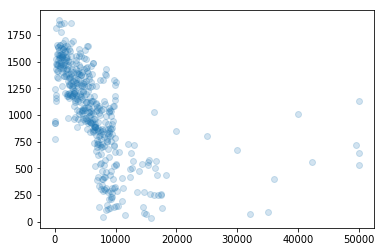

In [141]:
X = maxes.index
y = maxes['hours_till_funded']
plt.scatter(X, y, alpha=0.2)
plt.show()

It's interesting to see that downward trend. Although this is only maximums, it could shed light onto some issue Kiva has with promoting some of the loans that require more money, rather than promoting the loans for people who really need it. Let's take a look at the average and minimums as well, just to get an idea.

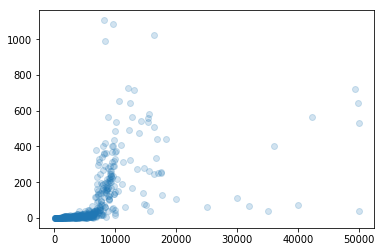

In [142]:
loan_groups = data.groupby('loan_amount')
mins = loan_groups.min()
means = loan_groups.mean()

plt.scatter(mins.index, mins['hours_till_funded'], alpha=0.2)
plt.show()

This minimums looked just about as I expected, with the minimums following a sort of exponential function. Smaller loans are bound to be able to be funded faster than bigger loans, so this makes sense

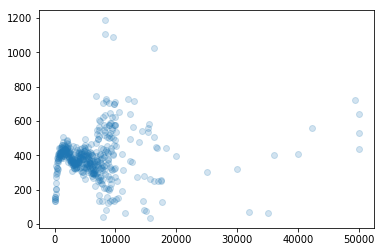

In [143]:
plt.scatter(means.index, means['hours_till_funded'], alpha=0.2)

Now the mean looks odd and intriguing. It has this sharp rise, then slowly fluctuates in a downward trend, which is odd considering there is no normalization. This indicates that some of the larger loans are simply being funded faster than smaller loans. Let's see if this just has to do with the number of loans in each bucket.

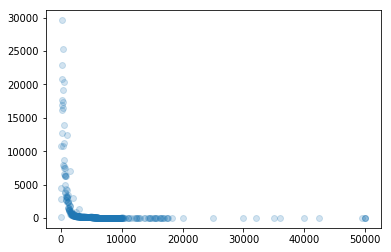

In [144]:
counts = loan_groups.count()

plt.scatter(counts.index, counts['hours_till_funded'], alpha=0.2)
plt.show()

This looks as expected. Maybe the average funding velocity (`loan_amount`/`hours_till_funded`) can give insights into the odd shape of the average funding time.

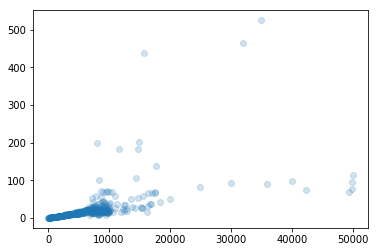

In [145]:
plt.scatter(means.index, means.index/means['hours_till_funded'], alpha=0.2)
plt.show()

So this is a very interesting graph. It implies that people tend to fund larger loans faster than smaller loans. This could be due to the amount of loans at each loan amount. If a lender lends money to one project from each price range, then it's obvious that due to the fact that there are fewer large loans, that they would get funded more. Still, this could be viewed as an issue, especially if Kiva wants the money to go to those who need it the most.

Now back to the task of populating the NaNs for the `hours_till_funded` feature, since we want a way to represent that this loan never got fully funded, but do so in a way that just makes the data significant, rather than leave them as NaN or give each of the loans that didn't get funded some arbitrarily large about of time to get funded. This is important so that whatever model we generate treates outliers locally rather than globally. We don't want the model to see the data and say "Oh wow look at these outliers", we want it to see the data as a whole have no particular outliers, but when looking at a subset of the data, see outliers. What we plan on doing is computing the average funding velocity (of the loans for which one can be computed) for a particular loan size (using LinearRegression), the use it to compute a prospective `expected_hours_till_funded`. We will then, under the assumption that the loan reached the amount it was funded when it reached the expected hours till funded, divide the expected hours by the percent of the loan that was funded for all of the loans that weren't fully funded, and use this new value as the hours till funded.

In [146]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

X = means.index.values.reshape(-1, 1)
y = (means.index/means['hours_till_funded'])

lin_reg.fit(X[:100], y[:100])
preds = lin_reg.predict(X)

The reason that we are only using part of the data to fit the linear regression is to ensure that the intercept is positive. Otherwise the smaller loans get a negative expected funing velocity, which isn't very useful

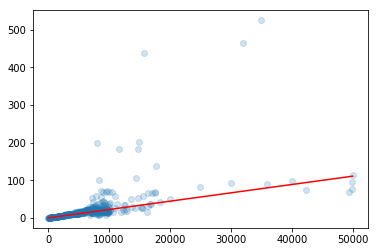

In [147]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X, preds, c='r')

Although this might not be perfect, especially for higher values, it should be a rather good way to predict how long a certain loan should take, based on how large that loan is. And even though this line only takes into account the first 100 loan amounts, it still produces line that fits the data rather well.

In [148]:
lin_reg.coef_[0], lin_reg.intercept_

(0.0022150186161036447, 0.27150944584848746)

In [149]:
f = lambda x: lin_reg.coef_[0]*x + lin_reg.intercept_

final_data['expected_funding_velocity'] = final_data['loan_amount'].apply(f)
final_data['expected_hours_till_funded'] = final_data['loan_amount']/final_data['expected_funding_velocity']

Next we need a percentage of the loan that way funded, and at the same time we will extract a boolean feature denoting whether or not the loan was fully funded.

In [150]:
final_data['percent_funded'] = final_data['funded_amount']/final_data['loan_amount']
final_data['fully_funded'] = final_data['funded_amount'] >= final_data['loan_amount']

Finally we can compute a theoretical amount of hours till loans that weren't fully funded might be funded by. This is bound to overshoot, but they are supposed to be large values since we want the model to take these into affect when determining how long it will take for a loan to be funded.

In [151]:
final_data['hours_till_funded'] = final_data['hours_till_funded'].fillna(final_data['expected_hours_till_funded']/final_data['percent_funded'])

Let's check out what this looks like. The red points are data that wasn't fully funded, whereas the green points were

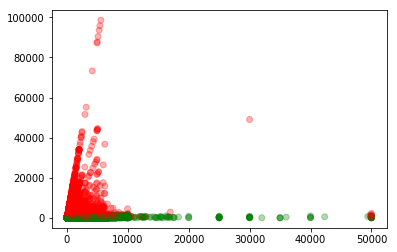

In [152]:
colors = ('r', 'g')
get_c = lambda i: colors[i]
inst_cols = final_data['fully_funded'].apply(get_c)
plt.scatter(final_data['loan_amount'], final_data['hours_till_funded'], c=inst_cols, alpha=0.3)
plt.show()

Here you can see that the red points in the data contain the values which we populated. This data might be a little concerning, given by how skewed the data is, but the point is for the loans that were not fully funded to be casted as outliers, but in an intelligent way, rather than just giving them some arbitrary value. Let's see how much of the data has a really high value (let's say greater than 2100 hours, since is looks like most of the green data stops about there. This is about 2.9 months)

In [153]:
(final_data['hours_till_funded'] > 2100).sum()

6577

Although this might be considered a lot, keep in mind the amount of data that we have in total. This is just a rather small portion of all the data we have.

In [154]:
((final_data['hours_till_funded'] > 2100).sum())/len(final_data)

0.012328923763874023

A whopping 1.2% of the data consists of data that falls way outside the trend, which is nothing to worry about. In fact, we hope that the model will pick up the significance of these loans in order to predict when an incoming loan has a high chance of taking way too long to be funded. This even includes a few 'inf' values, since some of the loans listed did not get funded at all. Let's see how many of those there are.

In [155]:
(final_data['hours_till_funded'] == float('inf')).sum()

2113

Note that this means there are only 6577 - 2113 = 4464 actual outliers, whereas the 'inf' values are a result of unfunded project, which we wouldn't describe as outliers, but just the way to numerically denote an unfunded project. This also has the implication (due to the fantastic properties of Python) that the `loan_amount`/`hours_till_funded` will be 0 whenever `hours_till_funded` is 'inf'.

In [156]:
final_data['funding_velocity'] = final_data['loan_amount']/final_data['hours_till_funded']

In [157]:
final_data[final_data['hours_till_funded'] == float('inf')][['hours_till_funded', 'funding_velocity']].drop_duplicates()

,hours_till_funded,funding_velocity
173914,inf,0.0


As you can see, all of the entries with 'inf' `hours_till_funded` also have 0 `funding_velocity`, which is great, because we don't have to do any more work for this feature, let's see what this data looks like plotted out

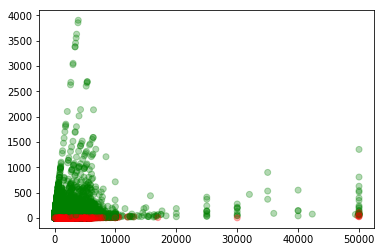

In [158]:
plt.scatter(final_data['loan_amount'], final_data['funding_velocity'], c=inst_cols, alpha=0.3)
plt.show()

Here, you can see that pretty much all of the red points have a rather low funding velocity, which was the intention of the formula used to fill in these null values. You can also see the slight upward trend like in the averages, which is a good indication that this data we added will work well with the model. Something else to notice is that quite a few of the filled in values seem rather normal. This ideally indicates that the loan was nearly funded, so rather than placing a significant marker on that data (like an infinite or really large hours_till_funded), the formula created a more reasonable guess as to what it might have been.

The last feature we can extract is `month_posted`, which we will explain our reasoning for later with some visualizations

In [159]:
final_data['month_posted'] = final_data['posted_time'].apply(lambda date: date.month)

In [160]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 93 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null datetime64[ns]
disbursed_time                       533461 non-null datetime64[ns]
funded_time                          499549 non-null datetime64[ns]
term_in_months                       533461 non-null float64
lender_count           

# Visualizations

Now we can take a better look of this data, now that it's as full as we could ever make it.

In [161]:
data = final_data.copy()

In [162]:
(data['funding_velocity'] == float('inf')).sum()

1100

Not really sure why there are a few infinite values for `funding_velocity`... I guess this means they were funded instantly/before the loan was posted. I'm going to remove these for now to make visualization possible.

In [163]:
# remove inf for plotting
plottable_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["funding_velocity"], how="all")

In [164]:
data = plottable_data.copy()

## Correlations

In [165]:
# correlations

numeric_data = data.select_dtypes(include=['float64'])

corr = numeric_data.corr()
corr["funding_velocity"]

funded_amount                        0.205840
loan_amount                          0.194283
term_in_months                      -0.028576
partner_id                          -0.040275
number                               0.036571
amount                               0.066287
lat                                 -0.062756
lon                                 -0.052382
rural_pct                            0.008764
mpi_national                        -0.027869
mpi_regional                        -0.025884
headcount_ratio_regional            -0.028228
intensity_of_deprivation_regional   -0.031656
mpi_urban                           -0.023638
headcount_ratio_urban               -0.025202
intensity_of_deprivation_urban      -0.037798
mpi_rural                           -0.022811
headcount_ratio_rural               -0.021330
intensity_of_deprivation_rural      -0.040817
mpi_region_lat                      -0.045762
mpi_region_lon                      -0.035605
ratio_male                        

No obvious correlations, at this point, apart from the `loan_amount` and `expected_funding_velocity` relationships we should expect.

In [166]:
corr["mpi_regional"]

funded_amount                        0.036962
loan_amount                          0.041569
term_in_months                      -0.006072
partner_id                           0.267224
number                               0.163880
amount                               0.029473
lat                                 -0.219723
lon                                 -0.069291
rural_pct                            0.203573
mpi_national                         0.765262
mpi_regional                         1.000000
headcount_ratio_regional             0.987892
intensity_of_deprivation_regional    0.635439
mpi_urban                            0.700235
headcount_ratio_urban                0.710108
intensity_of_deprivation_urban       0.566479
mpi_rural                            0.749011
headcount_ratio_rural                0.753715
intensity_of_deprivation_rural       0.482157
mpi_region_lat                      -0.227152
mpi_region_lon                      -0.070451
ratio_male                        

Nothing super surprising here. It's worth noting that `mpi_regional` and `headcount_ratio_regional` are nearly perfectly correlated.

## Temporal features

In [167]:
loan_timing = pd.DataFrame(data[['id', 'posted_time']])

In [168]:
loan_timing['hour_posted'] = data.posted_time.map(lambda row: row.hour)
loan_timing['weekday_posted'] = data.posted_time.map(lambda row: row.weekday())

In [169]:
loans_with_timing = pd.merge(loan_timing, data, on="id")

### Time of day/week/year posted

In [170]:
data_no_outliers = loans_with_timing.sort_values('funding_velocity', ascending=True)

In [171]:
data_no_outliers = data_no_outliers.head(round(len(data_no_outliers) * .98))

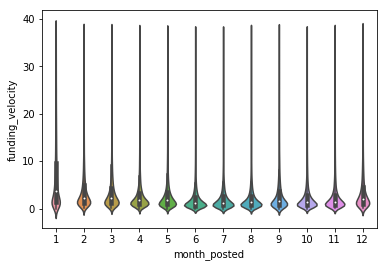

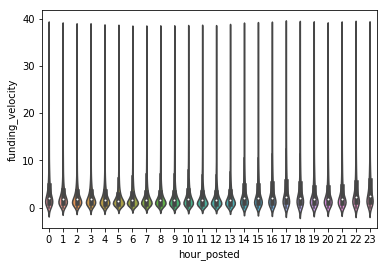

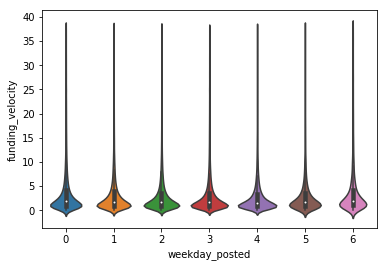

In [172]:
sns.violinplot(x="month_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

sns.violinplot(x="hour_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

sns.violinplot(x="weekday_posted", y="funding_velocity", data=data_no_outliers)
plt.show()

In [173]:
loans_with_timing.groupby('month_posted').mean()['funding_velocity']

month_posted
1     16.076731
2      7.124660
3      7.366669
4      3.446271
5      3.814926
6      3.222456
7      2.971670
8      3.405253
9      5.625670
10     3.262800
11     3.901473
12     9.642497
Name: funding_velocity, dtype: float64

It looks like loans posted in the winter (particularly around the holidays) generally have a higher funding velocity.

### Velocity over time

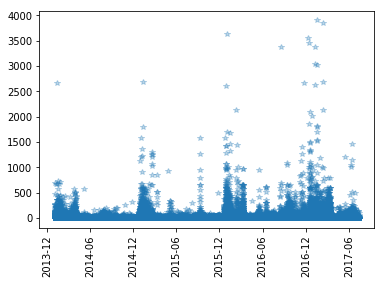

In [174]:
df = data.sort_values('posted_time', ascending=True)
plt.plot(df['posted_time'], df['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

Here again, we can see the trend for a spike in funding velocity around Dec/Jan every year.

## Loan Purpose

We have three features related to loan purpose: `sector`, `activity`, and `loan_theme_type`.

In [175]:
colors = ['#455e8e', '#7489ad']

def plot_categorical(category, dataset=data, numeric_feature='funding_velocity'):
    plt.figure(figsize=(15,8))
    count = round(dataset.groupby([category])[numeric_feature].mean().sort_values(ascending=False), 2)
    sns.barplot(count.values, count.index, )
    for i, v in enumerate(count.values):
        plt.text(0.8,i,v,color='k',fontsize=12)
    plt.xlabel(numeric_feature, fontsize=20)
    plt.ylabel(category, fontsize=20)
    plt.show()
    
def plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='sector', 
                     d=data, 
                     scale_first=True):
    # average by category, sort
    count_a = d.groupby([category])[feature_a].mean().sort_values(ascending=False).to_frame()
    count_a[category] = count_a.index.values
    # average by category
    count_b = d.groupby([category])[feature_b].mean().to_frame()
    count_b[category] = count_b.index.values
    # merge on sorted category
    counts = count_a.merge(count_b, how='left', on=category)
    # scale if necessary, plot
    if scale_first:
        counts[feature_a] = counts[feature_a]*100 # scale
    counts.plot(kind='bar', stacked=True, color=colors)

### Sector

In [176]:
len(data['sector'].unique())

15

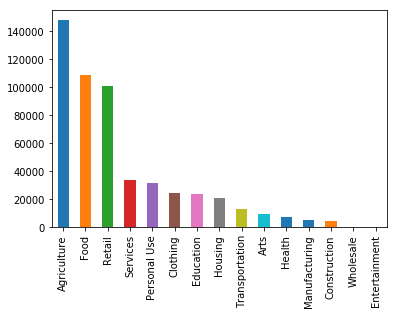

In [177]:
data.sector.value_counts().plot.bar()

This is by far our least granular category, with 15 values.

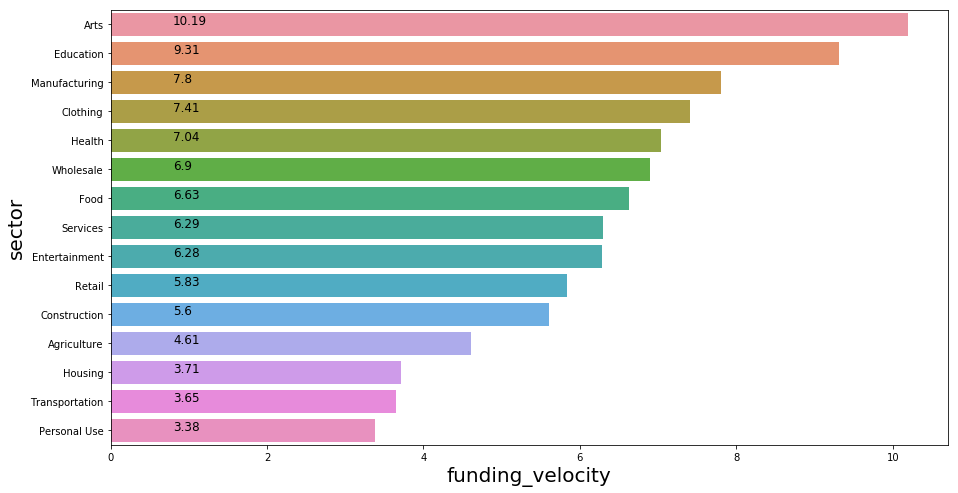

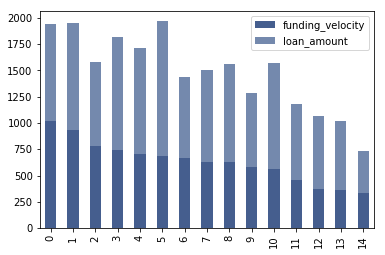

In [178]:
plot_categorical('sector', data)

plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='sector', 
                     d=data, 
                     scale_first=True)

Difference in `funding_velocity` for each category does not vary too closely with `loan_amount`, interestingly.

### Activity

In [179]:
len(data['activity'].unique())

163

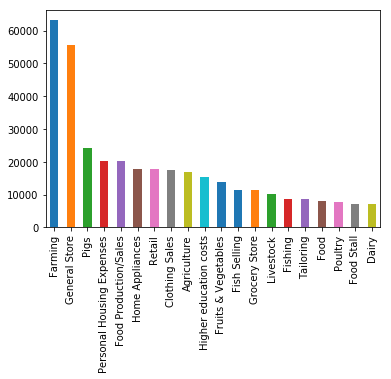

In [180]:
data.activity.value_counts().head(20).plot.bar()

Activity is significantly finer grained, with 163 values. Aside from being more fine-grained, the categories are very similar.

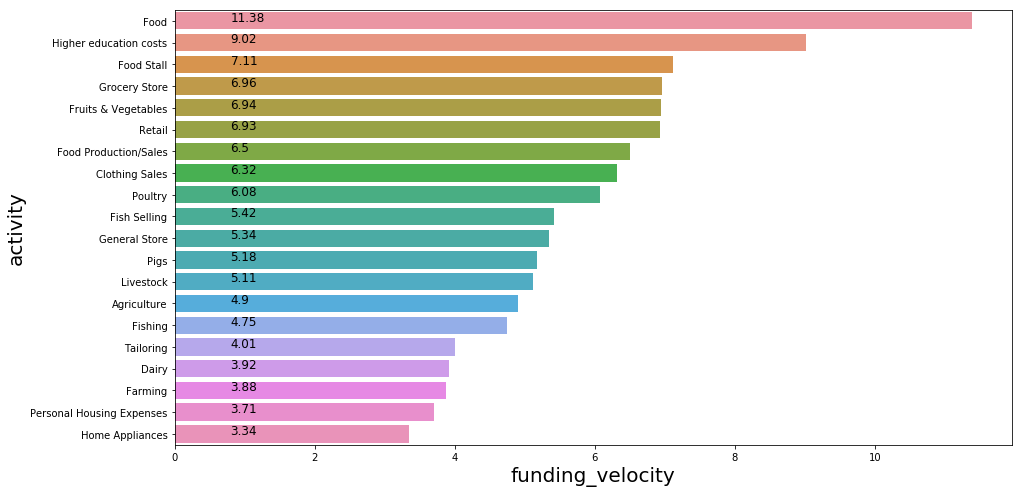

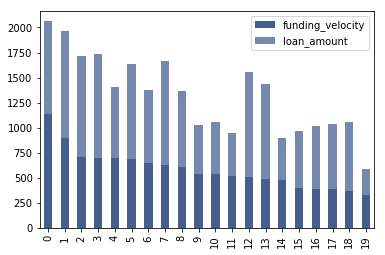

In [181]:
# plot velocity for most common activities
top_activities = data.activity.value_counts().head(20).index.values
activities = data.loc[data['activity'].isin(top_activities)]

plot_categorical('activity', activities)

plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='activity', 
                     d=activities, 
                     scale_first=True)

### Loan theme type

In [182]:
len(data['loan_theme_type'].unique())

160

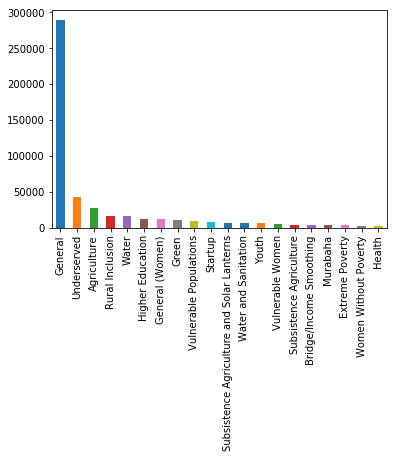

In [183]:
data.loan_theme_type.value_counts().head(20).plot.bar()

`loan_theme_type` is slightly less fine-grained than `activity`, with 110 values. The categories here are not the same, however. Rather than just looking at the usage, `loan_theme_type` takes into account qualities of the borrower (women entrepeneurs, for example.)

In [184]:
print((data.loan_theme_type != 'General').sum() / data.shape[0])
print((data.loan_theme_type == 'Women Entrepreneurs').sum())

0.45838256371146646
2077


40% of our data falls into the `general` theme.

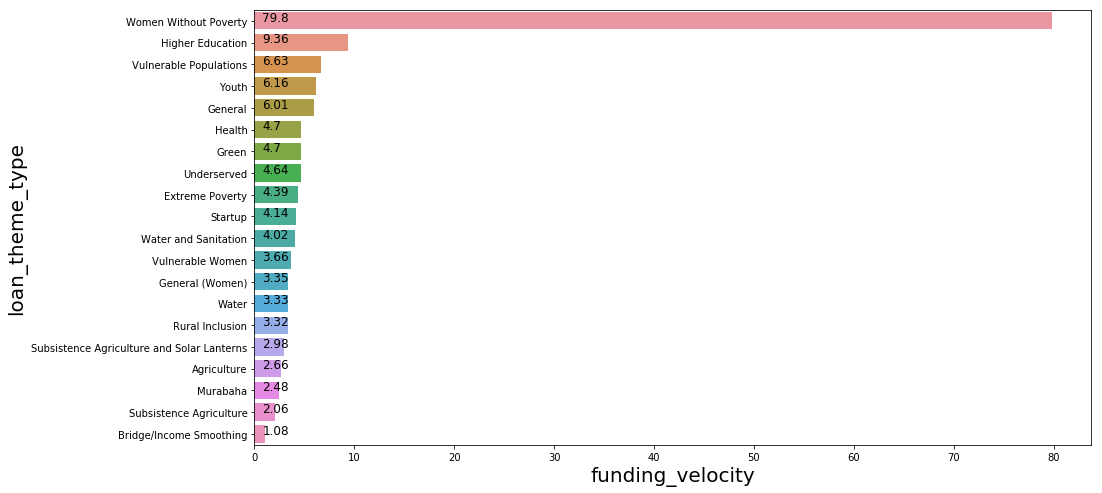

In [185]:
top_themes = data.loan_theme_type.value_counts().head(20).index.values
loans = data.loc[data['loan_theme_type'].isin(top_themes)]

plot_categorical('loan_theme_type', dataset=loans)

Despite the overwhelming `general` category, this feature is very interesting. We should look at it closer to see if we extract something from it in the feature transformation process.

## Country

In [186]:
print(len(data['country'].unique()))
data['country'].value_counts()

75


Philippines                         149517
Kenya                                63349
Cambodia                             32497
Pakistan                             26487
Uganda                               19101
Tajikistan                           19016
El Salvador                          15752
Peru                                 15295
Colombia                             13541
Ecuador                              10978
Nigeria                               9971
India                                 8794
Nicaragua                             8635
Bolivia                               8319
Paraguay                              8139
Palestine                             7771
Armenia                               7604
Samoa                                 6934
Lebanon                               6852
Guatemala                             5041
Honduras                              5025
Tanzania                              5022
Indonesia                             4899
Sierra Leon

#### Common countries

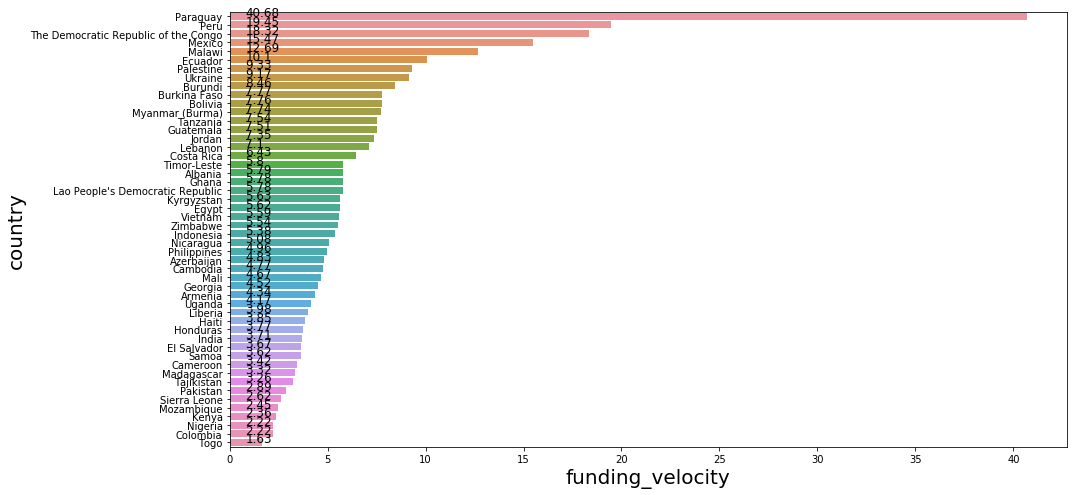

In [187]:
# plot velocity time for most common countries
top_countries = data.country.value_counts().head(50).index.values
countries = data.loc[data['country'].isin(top_countries)]

plt.figure(figsize=(15,8))
plot_categorical('country', countries)

There is significant variation in velocity between countries, so it definitely seems like a useful feature to include.

#### Least common countries

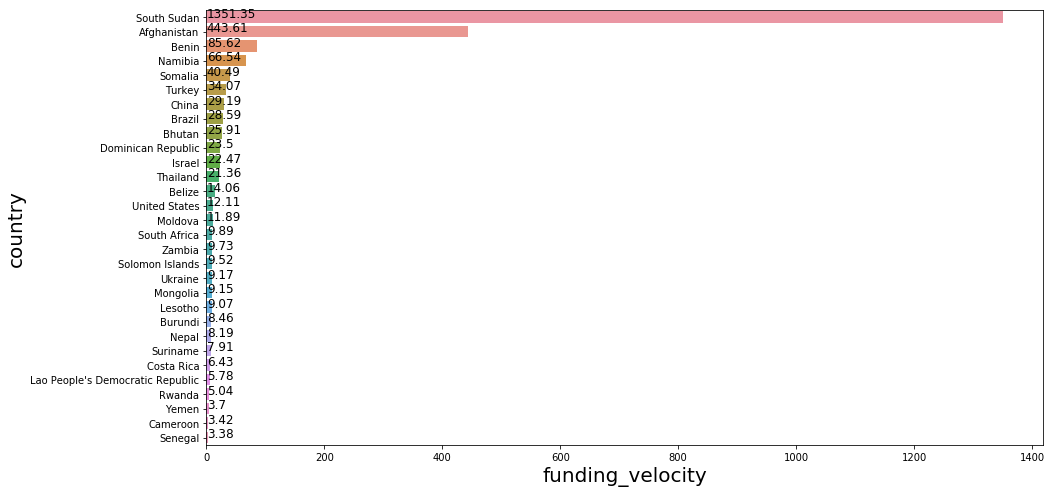

In [188]:
# plot velocity time for least common countries
top_countries = data.country.value_counts().tail(30).index.values
uncommon_countries = data.loc[data['country'].isin(top_countries)]

plt.figure(figsize=(15,8))
plot_categorical('country', uncommon_countries)

Variance not super meaningful with these countries–South Sudan has only one instance.

In [189]:
print(len(data[data['country'] == 'South Sudan']))

1


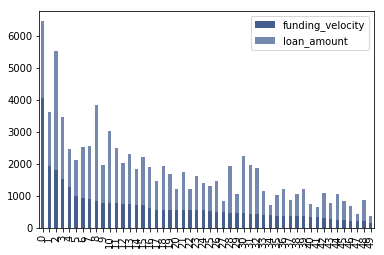

In [190]:
plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='country', 
                     d=countries, 
                     scale_first=True)

Here again, the funding velocity and loan amount are not closely related within each country.

## Loan Terms

### Repayment Interval

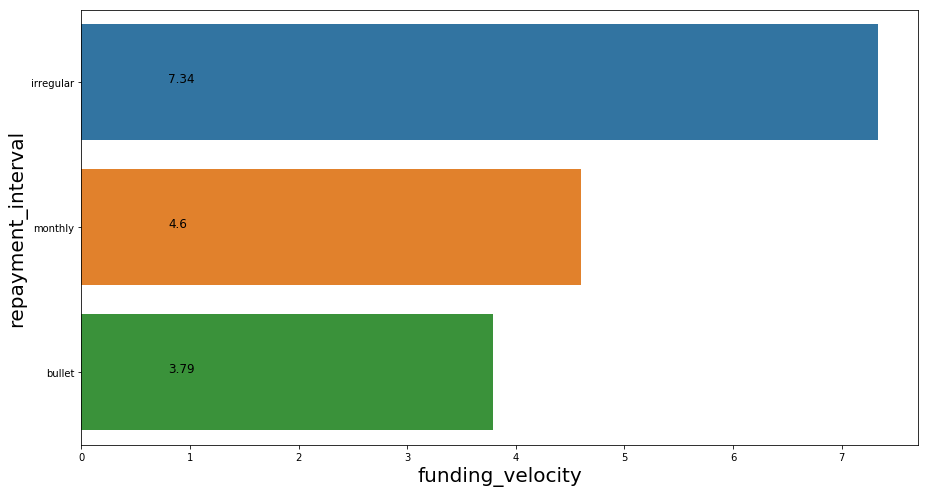

In [191]:
plot_categorical('repayment_interval', countries)

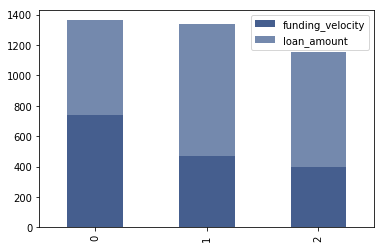

In [192]:
plot_stacked_bar(feature_a='funding_velocity', 
                     feature_b='loan_amount', 
                     category='repayment_interval', 
                     d=data, 
                     scale_first=True)

### Term in months

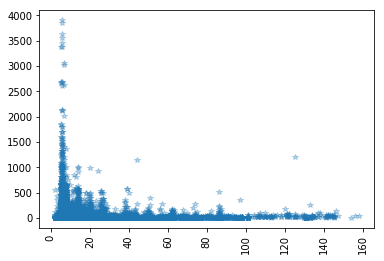

In [193]:
plt.plot(data['term_in_months'], data['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

### Lender Count

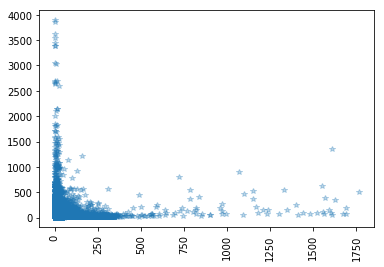

In [194]:
plt.plot(data['lender_count'], data['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

As I would expect, loans with few funders (larger donations) were funded exponentially faster. While this is an important factor, clearly, I wonder about including it in the feature set because we are trying to *predict* funding velocity ahead of time – `lender_count` is not a known factor until after the loan has been funded.

### Field Partner

In [195]:
print(data.field_partner_name.value_counts().head(20))
print("Total Unique Partners: " + str((data.field_partner_name.value_counts()).sum()))

Negros Women for Tomorrow Foundation (NWTF)    103663
CrediCampo                                      15424
Juhudi Kilimo                                   15391
iDE Cambodia                                    14447
BRAC Pakistan                                   13564
SMEP Microfinance Bank                          12987
Paglaum Multi-Purpose Cooperative (PMPC)        12909
Community Economic Ventures, Inc. (CEVI)        12311
HOFOKAM                                         10467
VisionFund Cambodia                             10437
Yehu Microfinance Trust                         10405
Interactuar                                     10331
VisionFund Kenya                                10325
Kashf Foundation                                10203
Babban Gona Farmers Organization                 9845
AsociaciÍ_n Arariwa                              9567
Humo                                             8292
IMON International                               8275
FundaciÍ_n Paraguaya        

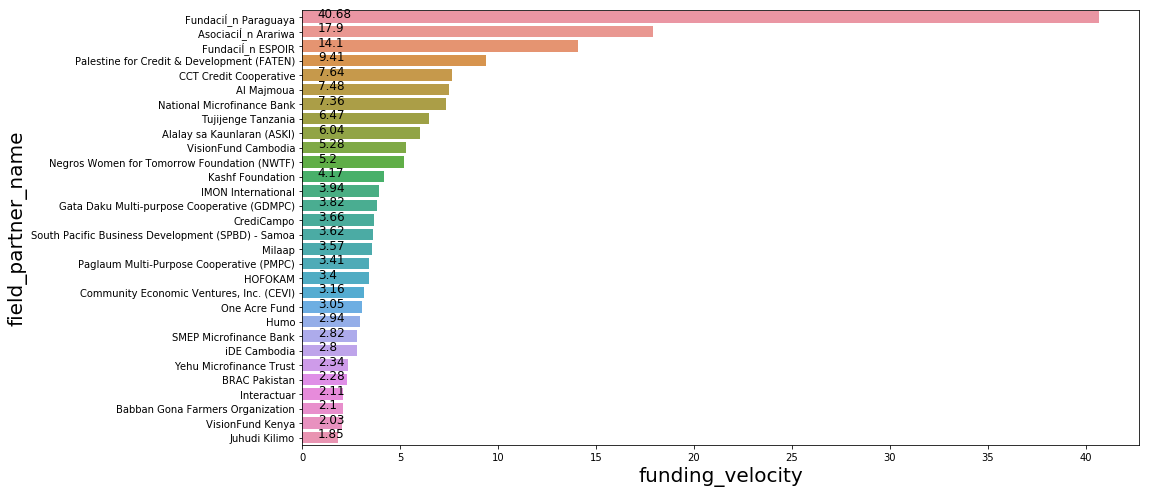

In [196]:
top_partners = data.field_partner_name.value_counts().head(30).index.values
partners = data.loc[data['field_partner_name'].isin(top_partners)]

plt.figure(figsize=(15,8))
plot_categorical('field_partner_name', partners)

I'm noticing that a lot of the field partners have places in the name. Lets see how closely related field partners are to countries.

In [197]:
for partner in top_partners:
    print(partner.upper())
    counts = data[data["field_partner_name"] == partner]['country'].value_counts()
    for i in range(len(counts)):
        print(counts.index[i])
        print(counts[i])
    print()

NEGROS WOMEN FOR TOMORROW FOUNDATION (NWTF)
Philippines
103663

CREDICAMPO
El Salvador
15424

JUHUDI KILIMO
Kenya
15391

IDE CAMBODIA
Cambodia
14447

BRAC PAKISTAN
Pakistan
13564

SMEP MICROFINANCE BANK
Kenya
12987

PAGLAUM MULTI-PURPOSE COOPERATIVE (PMPC)
Philippines
12909

COMMUNITY ECONOMIC VENTURES, INC. (CEVI)
Philippines
12311

HOFOKAM
Uganda
10467

VISIONFUND CAMBODIA
Cambodia
10437

YEHU MICROFINANCE TRUST
Kenya
10405

INTERACTUAR
Colombia
10331

VISIONFUND KENYA
Kenya
10325

KASHF FOUNDATION
Pakistan
10203

BABBAN GONA FARMERS ORGANIZATION
Nigeria
9845

ASOCIACIÍ_N ARARIWA
Peru
9567

HUMO
Tajikistan
8292

IMON INTERNATIONAL
Tajikistan
8275

FUNDACIÍ_N PARAGUAYA
Paraguay
8139

GATA DAKU MULTI-PURPOSE COOPERATIVE (GDMPC)
Philippines
7410

ONE ACRE FUND
Kenya
7187

SOUTH PACIFIC BUSINESS DEVELOPMENT (SPBD) - SAMOA
Samoa
6934

CCT CREDIT COOPERATIVE
Philippines
6917

PALESTINE FOR CREDIT & DEVELOPMENT (FATEN)
Palestine
6687

AL MAJMOUA
Lebanon
5925

FUNDACIÍ_N ESPOIR
Ecuador
5603


It looks like these partners are closely tied to countries. Lets see how closely countries are tied to partners.

In [198]:
top_countries = data.country.value_counts().head(30).index.values

for country in top_countries:
    print(country.upper())
    counts = data[data["country"] == country]['field_partner_name'].value_counts()
    for i in range(len(counts)):
        print(counts.index[i])
        print(counts[i])
    print()

PHILIPPINES
Negros Women for Tomorrow Foundation (NWTF)
103663
Paglaum Multi-Purpose Cooperative (PMPC)
12909
Community Economic Ventures, Inc. (CEVI)
12311
Gata Daku Multi-purpose Cooperative (GDMPC)
7410
CCT Credit Cooperative
6917
Alalay sa Kaunlaran (ASKI)
5509
SEED Center Philippines
620
BagoSphere
177
N/A, direct to Kalsada
1

KENYA
Juhudi Kilimo
15391
SMEP Microfinance Bank
12987
Yehu Microfinance Trust
10405
VisionFund Kenya
10325
One Acre Fund
7187
Hand in Hand Eastern Africa
3248
Kenya ECLOF
2849
Digital Divide Data (DDD)
233
Sanergy
225
Asante Kenya Foundation
152
iSmart Kenya
74
Junior Achievement Kenya
74
Takamoto Biogas
72
Burn Manufacturing
44
Housing Finance Foundation
29
Moringa School
24
Strathmore University
17
PowerGen Renewable Energy
2
Unreasonable Institute
2
N/A, direct to ICT4D
1
N/A, direct to LLK
1
N/A, direct to Pawame
1
N/A, direct to EcoZoom
1
N/A, direct to SCODE
1
Fledge
1
N/A, direct to Eco Fuels Kenya
1
N/A, direct to Vava Coffee
1
N/A, direct to Moko 

It seems like partners are a very local thing, tied closely to countries. Because of this, I doubt that kiva funders would have the background knowledge required to make partners a part of their decision. This could be looked at more,  but I'm going to put it aside for now.

Using countries (which partners are closely correlated with) is likely much more useful for our model.

## Currency

In [199]:
len(data['currency'].unique())

62

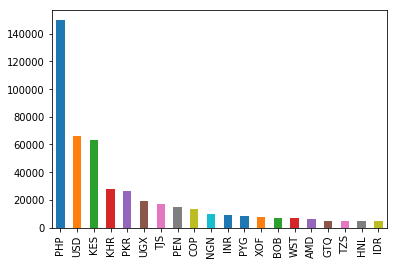

In [200]:
data.currency.value_counts().head(20).plot.bar()

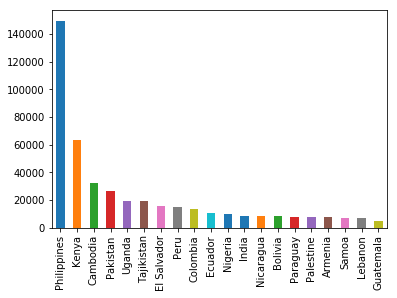

In [201]:
data.country.value_counts().head(20).plot.bar()

Looks like the main difference between country and currency is that USD is an aggregate of many countries.

In [202]:
usd = data[data["currency"] == "USD"]["country"].value_counts()
print("USD:")
print(usd)
print()

print("PHP:")
usd = data[data["currency"] == "PHP"]["country"].value_counts()
print(usd)

USD:
El Salvador                             15752
Ecuador                                 10978
Palestine                                7759
Lebanon                                  5783
Cambodia                                 4827
Nicaragua                                4094
Zimbabwe                                 3533
The Democratic Republic of the Congo     2963
Timor-Leste                              2386
Tajikistan                               1822
Armenia                                  1775
Bolivia                                  1347
Peru                                      742
Georgia                                   714
United States                             484
Mongolia                                  233
Kyrgyzstan                                214
Haiti                                     150
Ghana                                     112
Indonesia                                 103
Thailand                                  101
Honduras                     

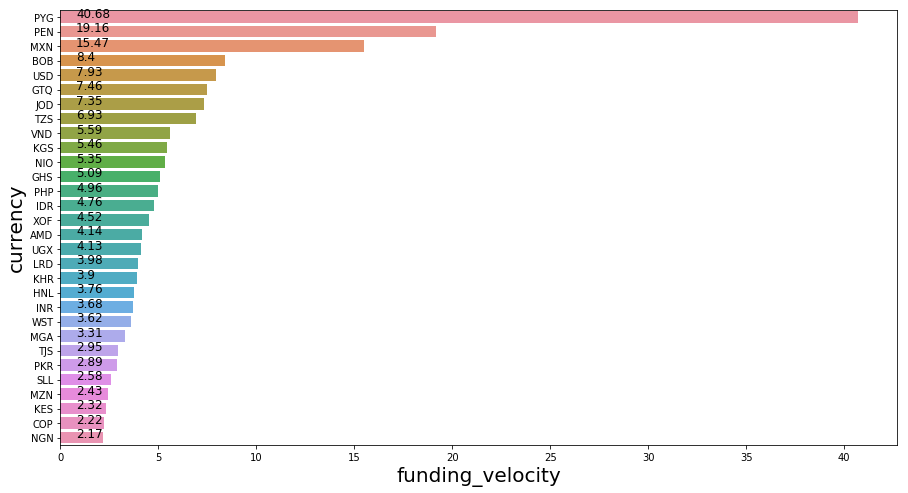

In [203]:
top = data.currency.value_counts().head(30).index.values
c = data.loc[data['currency'].isin(top)]

plot_categorical('currency', c)

Same general trends as the country feature.

## MPI dataset features

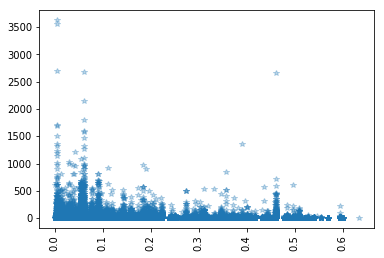

In [204]:
plt.plot(data['mpi_regional'], data['funding_velocity'], '*', alpha=0.3)
plt.xticks(rotation='vertical')

plt.show()

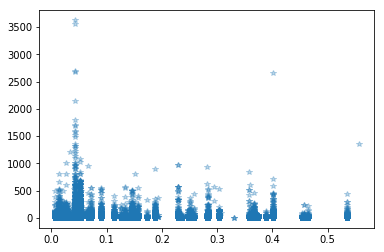

In [205]:
plt.plot(data['mpi_national'], data['funding_velocity'], '*', alpha=0.3)
plt.show()

Interestingly weak relationships here.

# Summary of Exlpored Features

#### Time of the year posted
There appears to be a spike in funding velocity around the holidays every year, and velocity also reaches a low point during the summer months. We will use this feature (`month_posted`) directly as a continuous value.

#### Loan Purpose
We have three main loan purpose related variables:
- `sector`: least granular (15 values), related solely to use
- `activity`:  more granular (160 values), related solely to use
- `loan_theme_type`: more granular (110 values), considers both use and borrower

We should look at these features a little closer in the transformation process, to see how much information we lose in going from `activity` to `sector` before deciding anything futher.

#### Country
Definitely should use, upon some transformation. It probably wouldn't hurt to group together some of the countries with only few instances, if nothing else. We will explore this later, but we definitely want to use it in some way.

#### Repayment Interval
Interestingly, irregular loan terms have the highest velocity. Although it might not seem like the best idea to convert this to a continuous variable, there is a sensible transformation that we will talk about later

#### Term in months
Loans with extremely low terms have a significant bump in velocity. We noticed that “short term loans” is actually a filter on Kiva’s website. Definitely useful.

#### Lender Count - Not useful?
While this shows a similar trend to the previous feature (low lender counts -> high velocity), we're doubtful about wether we should use it in our model because it’s not information that you will have available when predicting a loan’s velocity before it’s funded.

#### Field Partner - Not useful
Highly localized, not useful.


# Data Preparation (for ML)

Now, with a fully populated dataset, we can get into the "normal" ML process, and we'll start this out by taking a look at each feature to see what it is, what data it holds, and if it might be useful as a label or a feature.

- id: This is just a Kiva id that is not really all that useful, so it can probably be removed, since it shouldn't have anything to do with welfare level, just when the loan was created.
    * DROP
- funded_amount: This is definitely not a feature of the data, since what we are trying to do is predict a Percieved Poverty Index which should tell you how quickly a loan will be funded, so we won't know how much of the loan got funded at that period of time, so this can be dropped as well. In any case, this data is partially encoded in the funding velocity, which is effictively the main component of the PPI at this point.
    * DROP
- loan_amount: So this is definitely something that could be helpful in predicting the PPI, since the perception of need could correlate highly with the amount of money the borrower is asking for.
    * FEATURE
- activity: This feature has too many unique values to perform encoding on, but let's investigate further before doing anything
    * INVESTIGATE
- sector: As noted above, this is a less granular version of `activity`, and with only around 16 unique values, it shouldn't be an issue to use a one hot encoding. 
    * FEATURE
    * TRANSFORM
- use: We don't want to get into NLP, so we can just drop this
    * DROP
- country_code: Since we plan on using `country` in some way, this can be dropped
    * DROP
- country: Now we would like to use this feature, and we believe that the amount of features it would add (to do a one hot encoding) would be worth it, however we want to see if we can reduce the dimensionality by any amount in order to reduce the amount of features.
    * FEATURE
    * TRANSFORM
    * INVESTIGATE
- region: This is much too granular to try and find trends within regions, and it's not necessarily useful. People might make certain assumptions about the countries from which loans originate, however people most likely know nothing about the regions, so there probably isn't much correlation in this feature that there isn't already in the country feature.
    * DROP
- currency: This is an interesting one, however we don't think it really matters much to people loaning money, since we believe Kiva takes it upon themselves to handle different currencies. It also correlates highly with `country`, which we are already using as a feature, so this can be dropped.
    * DROP
- posted_time: This feature can not be used by a model due to the fact that it is a DateTime object, and since we've already extracted a useful feature from this information.
    * DROP
- disbursed_time: This is an interesting feature in that some of these times came before the `posted_time`, and others it was after the `funded_time`, which indicates that some third party gave the loan, and is using kiva to ensure that the third party stays funded. Because of this, it is hard to extract useful information (since this data may or may not be included in a new loan) and is in a non-numerical format, so it can be dropped
    * DROP
- funded_time: This was vital for extracing feature, but will not be useful in the model itself, since it is a DateTime object, so it can be dropped
    * DROP
- term_in_months: This is how long the borrower has to pay back the loan, which is potentially a large factor in how people choose what loans they lend money to (i.e. a 24 month loan means that the money might not come back very fast, which might indicate that the borrowers need the money more than someone who needs a loan they can pay back in 3 months), so this is definite feature.
    * FEATURE
- lender_count: This is actually more of a label than anything, but predicting the amount of lenders is less important than predicting how quickly a loan will be funded (even though they might be related), so we will drop it.
    * DROP
- repayment_interval: This feature is one of three strings: 'irregular', 'monthly', and 'bullet'. The first here means that the borrower(s) will pay whenever they can. 'monthly' is fairly self-explanatory, and 'bullet' is when the borrower(s) pay back the entire loan at the end of the lending period. Since we can't use this on it's own, we will have to tranform it to some numerical representation. The most obvious to us is to have them labeled numerically in this order; monthly, irregular, bullet. This should follow somewhat with the length of the payment interval. The reason we placed irregular in the middle is that we believe those who don't think they can pay each month with opt for irregular, expecting they might not have the money within a month.
    * FEATURE
    * TRANSFORM
- loan_theme_id: This is some long string of characters that is of no use to a model, so it can be dropped
    * DROP
- loan_theme_type: We are uncertain about whether or not this feature would be useful to encode, so we'll have to investigate further
    * INVESTIGATE
- partner_id: This is just a feature used for earlier merges, so this can be dropped, since it doesn't have much to do with the PPI
    * DROP
- field_partner_name: There are way too many different values for this feature, which means it would be impossible to encode it numerically without taking up a ton of space, so we will just drop it.
    * DROP
- sector_ltbr: Some of this data might be useful, but we are already encoding sector, so we can just drop this feature
    * DROP
- forkiva: Although this is an interesting feature, people most likely don't know whether or not a particular loan is or is not 'forkiva', so it won't be very useful in predicting the PPI
    * DROP
- iso: This completely correlated with country, so there isn't much of a reason to keep it, especially if we keep the data for country.
    * DROP
- number: This is the number of loans coming from a perticular field partner for a particular loan theme, which isn't availible to someone trying to lend money on Kiva
    * DROP
- amount: This is similar to the above feature, but denotes the total amount of money funded by a particular field partner in a particular region for a perticular loan theme, which is data most people lending money do not have, so this can be droppped
    * DROP
- locationname: This is just the `mpi_region` and `country` combined into one string, so it isn't all that useful.
    * DROP
- names: This has way to much information in it to be useful in a model, so it can be dropped
    * DROP
- lat, lon: These can be dropped, since we don't want to use numerical location features.
    * DROP
- mpi_region: This is similar to `region`, but significantly less granular, with just over 6% of the values. This might be useable, but it might be difficult to enumerate the data. It also goes to say that these particular regions are somewhat arbitrary, and it might not be completely obvious to a lender.
    * DROP
- rural_pct: Although a lender might not know this exact value, it is likely they at least have some idea regarding how urban a certain country/region is, so this could be an important factor in determining the PPI of a particular loan. In any case, the model will be able to determine whether or not this information is important, so it can be a feature.
    * FEATURE
- world_region: With only 6 different values, this would not be hard to encode, and gives the least granular indication for the location of a loan, which is what a lender is most likely to know. It might be interesting to combine this with something like `country` in order to reduce the dimensionality of the data, so we'll have to investigate this.
    * FEATURE
    * TRANSFORM
    * INVESTIGATE
- mpi_national, mpi_regional, headcount_ratio_regional, intensity_of_deprivation_regional, mpi_urban, headcount_ratio_urban, intensity_of_deprivation_urban, mpi_rural, headcount_ratio_rural, intensity_of_deprivation_rural: These features are all fairly granular data that could be vital to predicting PPI, so these are all features.
    * FEATURE
- mpi_region_lat, mpi_region_lon: These are numarical location features, which we don't want to use, so they can be dropped
    * DROP
- tag_\*: All of the tag_ features are going to play heavily in how Kiva displays a certain loan, so they could all be very important in predicting PPI
    * FEATURE
- num_tags: Although in theoty this data is encapsulated in the tag_ features, it can't hurt to aggregate the data so that the model doesn't have to figure it out on its own
    * FEATURE
- num_borrowers, num_male_borrowers, ratio_male, num_female_borrowers, ratio_female: These might play an interesting role in computing the PPI, and we extracted them all, so it would be a waste to throw them out.
    * FEATURE
- time_till_funded: This was just an intermediary feature for computing `hours_till_funded`, and since it is a TimeDelta, it can be dropped.
    * DROP
- hours_till_funded: This is without a doubt some sort of label, since this is only information that can be extracted after the loan has gotten funding, but predicting this might be an issue. This and `funded_amount` were used to compute `funding_velocity`, so in theory all of the information in the feature is encoded within funding velocity, so it can safely be dropped
    * DROP
- expected_funding_velocity: This is computed from a linear regression, and we don't want the model we use to predict PPI to just fit the simple linear model.
    * DROP
- expected_hours_till_funded: This feature is just a transformation of `expected_funding_velocity`, so it has the same issues with that feaure
    * DROP
- percent_funded, fully_funded: These two are definitely labels, and they are very similar to one another. Because of this, it seems rather pointless to have them both as labels, since it would just mean more computation. Although `percent_funded` could be useful, it it far too likely for the model to never give a full 100% to predictions, which is inaccurate, since most loans will get funded. Because of this, we believ it should be dropped, and just use `fully_funded`. It will have to be transformed however so that false has a value of -1, and true a value of 1, so that it will be an easy tranformation after prediction to just say anything > 0 is true, and anything < 0 is false.
    * DROP `precent_funded`
    * LABEL `fully_funded`
        - TRANSFORM
- funding_velocity: This is the main label of this entire dataset, and is effectively what the PPI is, so there is no doubt that this will be kept as a label. Since there aren't a ton of entries where this is 'inf', we will just drop them for simplicity
    * LABEL
    * DROP 'inf'

The first thing we'll do is write this dataset to disk, reset the kernel, and re-read the file back in, so that we have a nice clean version of the dataset right off the bat, rather than having to re-run the kernel every time if we mess something up.

In [206]:
final_data.to_csv('final_data.csv')

### Reset and Imports

In [207]:
%reset -f
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Re-read the data

In [208]:
final_data = pd.read_csv('final_data.csv', index_col=0)
tag_keys = [key for key in final_data.keys() if key.startswith('tag_')]
final_data[tag_keys] = final_data[tag_keys].astype(np.uint8)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 93 columns):
id                                   533461 non-null int64
funded_amount                        533461 non-null float64
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
use                                  533456 non-null object
country_code                         533453 non-null object
country                              533461 non-null object
region                               533461 non-null object
currency                             533461 non-null object
posted_time                          533461 non-null object
disbursed_time                       533461 non-null object
funded_time                          499549 non-null object
term_in_months                       533461 non-null float64
lender_count                         533461 non

Now we can drop all of the columns we won't be using

In [209]:
drop_labels = \
'''
id
funded_amount
use
country_code
region
currency
posted_time
disbursed_time
funded_time
lender_count
loan_theme_id
partner_id
field_partner_name
sector_ltbr
forkiva
iso
number
amount
locationname
names
lat
lon
mpi_region
mpi_region_lat
mpi_region_lon
time_till_funded
hours_till_funded
expected_funding_velocity
expected_hours_till_funded
percent_funded
'''.split('\n')[1:-1]

final_data.drop(drop_labels, axis=1, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533461 entries, 0 to 533460
Data columns (total 63 columns):
loan_amount                          533461 non-null float64
activity                             533461 non-null object
sector                               533461 non-null object
country                              533461 non-null object
term_in_months                       533461 non-null float64
repayment_interval                   533461 non-null object
loan_theme_type                      533461 non-null object
rural_pct                            533461 non-null float64
world_region                         470898 non-null object
mpi_national                         470898 non-null float64
mpi_regional                         470898 non-null float64
headcount_ratio_regional             470898 non-null float64
intensity_of_deprivation_regional    470898 non-null float64
mpi_urban                            470898 non-null float64
headcount_ratio_urban                4708

Since we aren't touching any of the features that have a good amount of NaN values (like `mpi_national`), we can now drop all NaNs to get a fully populated dataset before investigating some features and transforming others. We can also drop all of the data where `funding_velocity` is 'inf', since this data can't be used with machine learning.

In [210]:
final_data = final_data.dropna()
final_data = final_data[final_data['funding_velocity'] != float('inf')]
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469808 entries, 0 to 533459
Data columns (total 63 columns):
loan_amount                          469808 non-null float64
activity                             469808 non-null object
sector                               469808 non-null object
country                              469808 non-null object
term_in_months                       469808 non-null float64
repayment_interval                   469808 non-null object
loan_theme_type                      469808 non-null object
rural_pct                            469808 non-null float64
world_region                         469808 non-null object
mpi_national                         469808 non-null float64
mpi_regional                         469808 non-null float64
headcount_ratio_regional             469808 non-null float64
intensity_of_deprivation_regional    469808 non-null float64
mpi_urban                            469808 non-null float64
headcount_ratio_urban                4698

Now we can move on to investigating how we might encode non-numerical features

In [211]:
data = final_data.copy()
total_instances = data.shape[0]

In [212]:
def plot_categorical(category, dataset=data, numeric_feature='funding_velocity'):
    plt.figure(figsize=(15,8))
    count = round(dataset.groupby([category])[numeric_feature].mean().sort_values(ascending=False), 2)
    sns.barplot(count.values, count.index, )
    for i, v in enumerate(count.values):
        plt.text(0.8,i,v,color='k',fontsize=12)
    plt.xlabel(numeric_feature, fontsize=20)
    plt.ylabel(category, fontsize=20)
    plt.show()

## Approach

When determining what categories are important for our model, we will consider two main things:

1. How rare is this category? Keeping extremely rare categories will add unecesary dimensionality and potentially cause overfitting. We'll set the threshold for how common categories need to be to be considered significant at 2%.

2. How much does this category tell me that my other features don't? If we already have another feature with a similar relationship to the label class, it's less important to keep.

## Activities

In [213]:
alpha = 0.02

In [214]:
for activity in data["activity"].sample(100):
    counts = data[data["activity"] == activity]["sector"].value_counts()
    if (len(counts) != 1): 
        print("More than one associated sector")

We can see that each activity is related to exactly one sector, or in other words, activities are direct subcategories of sector.

Let's see if there are any levels for `activity` in which the average velocity of the instances within that level is very different from the average velocities of the instances in that level's associated sector.

In [215]:
# get average velocities for each category
s_velocity = data.groupby(['sector'])['funding_velocity'].mean()
a_velocity = data.groupby(['activity'])['funding_velocity'].mean()
activity_counts = data.activity.value_counts()

In [216]:
# find activities that are highly distinct from associated sector
distinct = pd.DataFrame()

for activity in data.activity.value_counts().index.values:
    # get associated sector
    sector = data[data["activity"] == activity]["sector"].values[0]
    # check if the average velocity for sector is very different from activity
    variation =  a_velocity[activity] - s_velocity[sector]
    if abs(variation) > 3:
        distinct = distinct.append(
            {"activity": activity, 
            "sector": sector, 
            "variation" : variation,
            "count" : activity_counts[activity]},
            ignore_index=True)
        
print("Num instances at a level to consider that level significant: " + str(round(total_instances * alpha)))
print()
print(distinct)

Num instances at a level to consider that level significant: 9396

                          activity   count         sector   variation
0   Primary/secondary school costs  3009.0      Education   -4.829989
1               Education provider  2878.0      Education    5.203340
2        Personal Medical Expenses  2458.0         Health   -3.403891
3                       Embroidery  1983.0           Arts   -3.994440
4                         Hardware   749.0         Retail    4.343838
5                       Used Shoes   604.0       Clothing    5.504562
6                Natural Medicines   500.0         Health    4.890419
7                         Textiles   448.0           Arts    6.115519
8                           Health   409.0         Health    4.665626
9                         Printing   317.0       Services   11.296186
10                       Bookstore   312.0         Retail    6.213100
11       Renewable Energy Products   287.0         Retail   25.292051
12                     

We can see that there are some cases of variation between activity velocity and that activity's asoiciated sector velocity, but in the cases with high variation, the number of features belonging to that category is too small to justify adding the feature to our dataset.

With little significant variation in activity, we will assume that using sector as our only feature is fine. Let's take a closer look at sector.

## Sector

In [217]:
sectors = data.sector.value_counts().index.values
print(len(sectors))

15


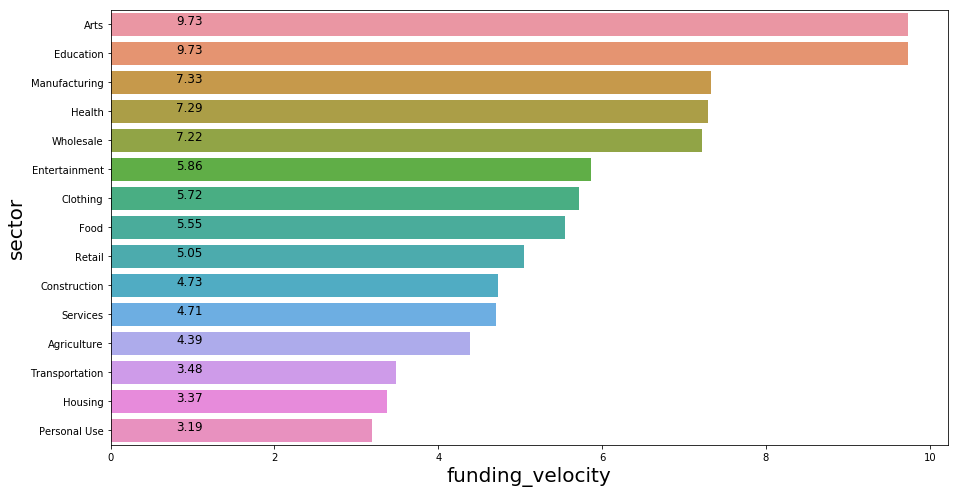

In [218]:
plot_categorical("sector")

In [219]:
total_instances = data.shape[0]
insig = []

for s in sectors:
    freq = len(data[data["sector"] == s])
    percent = (freq / total_instances)
    if percent < alpha:
        insig.append(s)
        
print(len(insig))

6


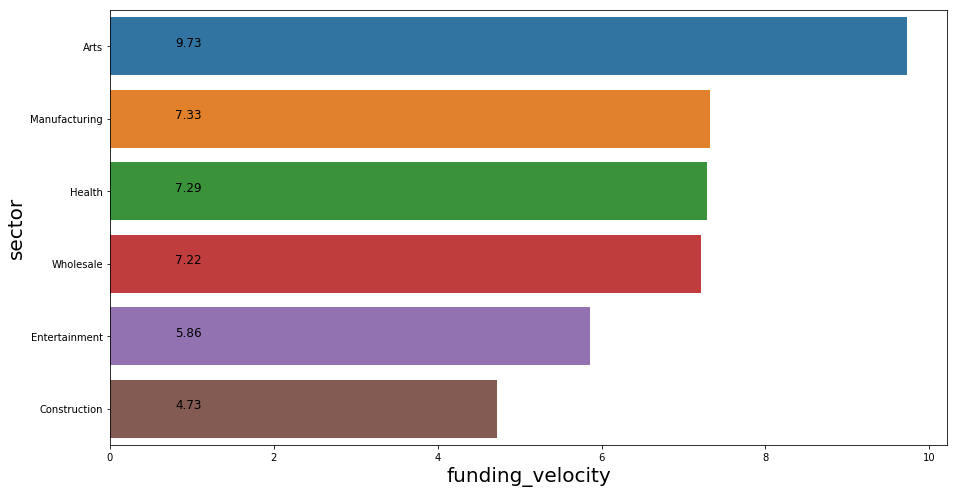

In [220]:
plot_categorical("sector", data.loc[data['sector'].isin(insig)])

Let's simplify these into two categories.

In [221]:
replacements = {
    sector:
    'low' if s_velocity[sector] > 6 else 'high'
    for sector in insig
}
        
data = data.replace({"sector" : replacements})
data.sector.value_counts()

Agriculture       130678
Food               99112
Retail             95027
Personal Use       29113
Services           28305
Clothing           21089
Housing            17673
low                17067
Education          15464
Transportation     12084
high                4196
Name: sector, dtype: int64

## Loan Themes

In [222]:
themes = data.loan_theme_type.value_counts().index.values
print(len(themes))

110


As before, lets start by finding how many categories occur frequently enough to be considered as unique categories.

In [223]:
total_instances = data.shape[0]

sig = []
insig = []

for t in themes:
    freq = len(data[data["loan_theme_type"] == t])
    percent = (freq / total_instances)
    if percent > alpha:
        sig.append(t)
    else:
        insig.append(t)
        
print(sig)

['General', 'Underserved', 'Agriculture', 'Water', 'Rural Inclusion', 'General (Women)']


Only 6 categories fit enough data to be considered without grouping, with one being 'general'.

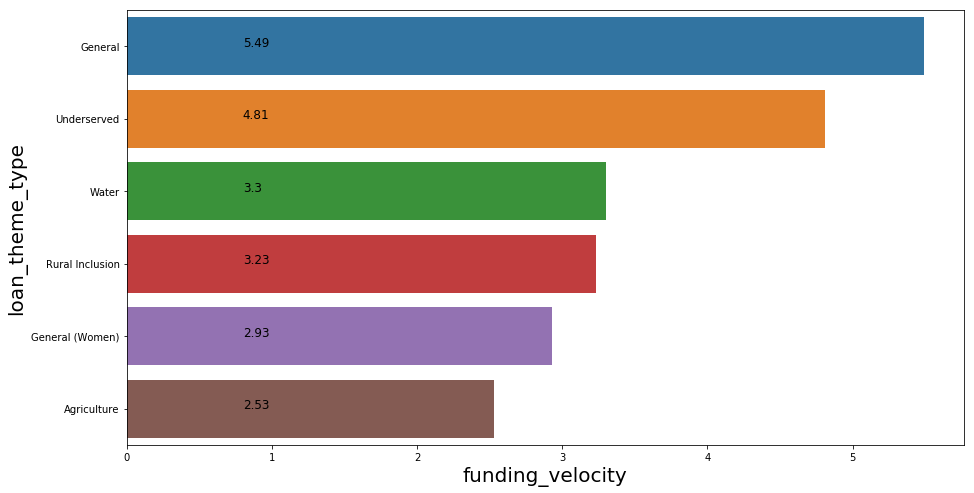

In [224]:
# plot velocity for most for significant
significant = data.loc[data['loan_theme_type'].isin(sig)]

plot_categorical('loan_theme_type', significant)

Now that we know what categories are present enough to be significant, let's look at how much the values in these significant categories differ from the values in their associated `sector` for their relationship to our label, `funding_velocity.`

In [225]:
for theme in sig:
    print(theme.upper())
    counts = data[data["loan_theme_type"] == theme]["sector"].value_counts()
    counts = counts[counts > total_instances * 0.01]
    print(counts)
    print()

GENERAL
Retail            77428
Food              77255
Agriculture       59098
Services          16634
Clothing          15323
low                9935
Transportation     7851
Housing            6512
Name: sector, dtype: int64

UNDERSERVED
Retail         6988
Food           6722
Agriculture    5283
Name: sector, dtype: int64

AGRICULTURE
Agriculture    23776
Name: sector, dtype: int64

WATER
Personal Use    14523
Name: sector, dtype: int64

RURAL INCLUSION
Agriculture    7327
Name: sector, dtype: int64

GENERAL (WOMEN)
Series([], Name: sector, dtype: int64)



We can see that, apart from general, most of our significant themes relate closely to one of our sectors. Undeserved is the one exception to this rule. Let's take a closer look at that.

In [226]:
avg_for_theme = data.groupby(['sector', 'loan_theme_type']).mean()
avg_for_theme.sort_index(inplace=True)

retail_avg = avg_for_theme.loc[('Retail', 'Underserved')]["funding_velocity"]
food_avg = avg_for_theme.loc[('Food', 'Underserved')]["funding_velocity"]
agr_avg = avg_for_theme.loc[('Agriculture', 'Underserved')]["funding_velocity"]

avg = data.groupby(['sector'])["funding_velocity"].mean()

print(abs(avg["Retail"] - retail_avg))
print(abs(avg["Food"] - food_avg))
print(abs(avg["Agriculture"] - agr_avg))

1.2892471906122411
0.17302638319726515
3.9821045188375193


We can see that instances belonging to the category `undereserved` do not have much of a deviation from the average of their associated sector in their relationship to `funding_velocity.` This leads us to assume that it may not be too important to include along with our `sector` feature.

Based on this analysis, we will not lose a lot of information by excluding the `loan_theme_type` category. This category is not worth the dimensionality it adds.

## Countries

In [227]:
insig_countries = []

countries = data.country.value_counts().index.values

for c in countries:
    freq = len(data[data["country"] == c])
    percent = (freq / total_instances)
    if percent < alpha:
        insig_countries.append(c)
        
print(len(insig_countries))

43


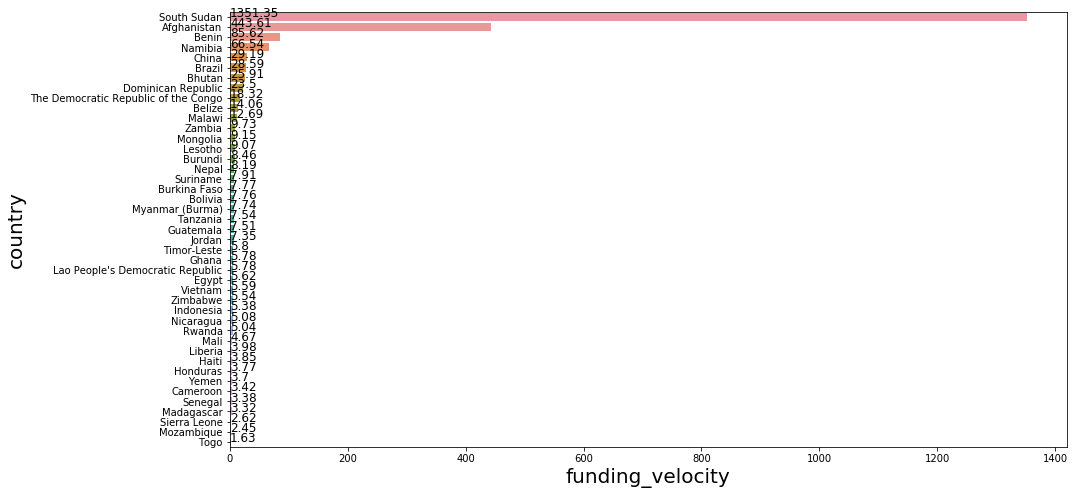

In [228]:
# plot velocity for most for insignificant
insignificant = data.loc[data['country'].isin(insig_countries)]

plot_categorical('country', insignificant)

In [229]:
country_avgs = data.groupby(['country'])['funding_velocity'].mean()
region_avgs = data.groupby(['world_region'])['funding_velocity'].mean()
country_counts = data.country.value_counts()

for country in insig_countries:
    count = country_counts[country]
    c_avg = country_avgs[country]
    region = data[data["country"] == country]["world_region"].iloc[0]
    r_avg = region_avgs[region]
    if((abs(c_avg - r_avg) * count) > (total_instances * alpha * 2)):
        print(country.upper() + " with average: " + str(c_avg))
        print(region + ": " + str(r_avg))
        print(count)
        print()
        insig_countries.remove(country)

NICARAGUA with average: 5.075951934492223
Latin America and Caribbean: 7.972147177130518
8635

HONDURAS with average: 3.7733083133921514
Latin America and Caribbean: 7.972147177130518
5025

THE DEMOCRATIC REPUBLIC OF THE CONGO with average: 18.322196809555788
Sub-Saharan Africa: 3.7564169678230885
2963



These few countries have significant deviation in their relation to our label from the average in their world region, and encompass a reasonable percent of the dataset. Based on this logic, we'll move them to the "significant" list.

Now lets simplify the rest of the countries by their world region.

In [230]:
replacements = {}

for country in insig_countries:
    replacements[country] = data[data["country"] == country]["world_region"].iloc[0]
        
data = data.replace({"country" : replacements})
data.country.value_counts()

Philippines                             149517
Kenya                                    63349
Sub-Saharan Africa                       39359
Cambodia                                 32497
Pakistan                                 26487
Uganda                                   19101
Tajikistan                               19016
Latin America and Caribbean              17238
El Salvador                              15752
Peru                                     15295
East Asia and the Pacific                14268
Colombia                                 13541
Ecuador                                  10978
Nigeria                                   9971
Nicaragua                                 8635
Arab States                               6113
Honduras                                  5025
The Democratic Republic of the Congo      2963
South Asia                                 703
Name: country, dtype: int64

We are ending up with a couple levels with very rare occurences, but we know those levels are distinct either geographically (South Asia) or in their relationship with the label (Congo), so I hesitate to further combine them.

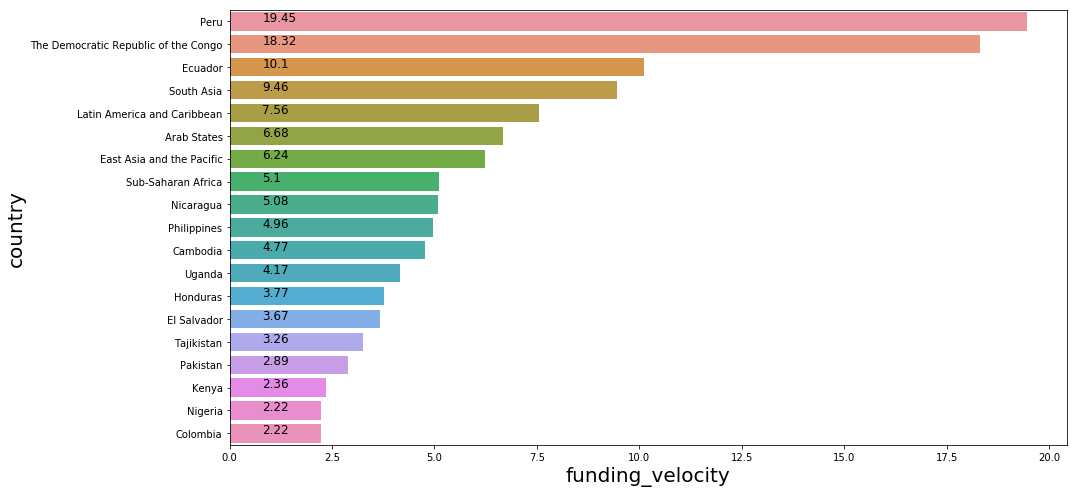

In [231]:
plot_categorical("country", dataset=data)

## Dummification & Dropping

In [232]:
data.drop(['activity', 'loan_theme_type', 'world_region', 'repayment_interval'], axis=1, inplace=True)

In [233]:
data = pd.get_dummies(data, columns=["country", "sector"], drop_first=True)

In [234]:
data.sample(5)

,loan_amount,term_in_months,rural_pct,mpi_national,mpi_regional,headcount_ratio_regional,intensity_of_deprivation_regional,mpi_urban,headcount_ratio_urban,intensity_of_deprivation_urban,...,sector_Clothing,sector_Education,sector_Food,sector_Housing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_high,sector_low
338351,225.0,7.0,69.0,0.052,0.055,11.200000,49.000000,0.035,8.1,42.7,...,0,0,1,0,0,0,0,0,0,0
7935,450.0,19.0,20.0,0.281,0.158,34.100000,46.300000,0.130,29.5,44.0,...,0,0,0,0,0,0,1,0,0,0
448979,125.0,8.0,69.0,0.052,0.054,11.600000,46.500000,0.035,8.1,42.7,...,0,0,1,0,0,0,0,0,0,0
441982,125.0,11.0,0.0,0.464,0.442,80.096552,54.444828,0.271,56.3,48.2,...,0,0,1,0,0,0,0,0,0,0
7969,1175.0,14.0,30.0,0.072,0.047,11.900000,40.100000,0.015,3.8,40.0,...,0,0,1,0,0,0,0,0,0,0


In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469808 entries, 0 to 533459
Data columns (total 85 columns):
loan_amount                                     469808 non-null float64
term_in_months                                  469808 non-null float64
rural_pct                                       469808 non-null float64
mpi_national                                    469808 non-null float64
mpi_regional                                    469808 non-null float64
headcount_ratio_regional                        469808 non-null float64
intensity_of_deprivation_regional               469808 non-null float64
mpi_urban                                       469808 non-null float64
headcount_ratio_urban                           469808 non-null float64
intensity_of_deprivation_urban                  469808 non-null float64
mpi_rural                                       469808 non-null float64
headcount_ratio_rural                           469808 non-null float64
intensity_of_deprivation_

Now that transforming the non numerical data is finished, the last thing to do is tranform the `fully_funded` to an integer like we mentioned in the feature overview. We can also reassign `final_data` to contain what `data` now holds

In [236]:
final_data = data
transform = (-1, 1)
final_data['fully_funded'] = final_data['fully_funded'].apply(lambda e: transform[e]).astype(np.int8)

In [237]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469808 entries, 0 to 533459
Data columns (total 85 columns):
loan_amount                                     469808 non-null float64
term_in_months                                  469808 non-null float64
rural_pct                                       469808 non-null float64
mpi_national                                    469808 non-null float64
mpi_regional                                    469808 non-null float64
headcount_ratio_regional                        469808 non-null float64
intensity_of_deprivation_regional               469808 non-null float64
mpi_urban                                       469808 non-null float64
headcount_ratio_urban                           469808 non-null float64
intensity_of_deprivation_urban                  469808 non-null float64
mpi_rural                                       469808 non-null float64
headcount_ratio_rural                           469808 non-null float64
intensity_of_deprivation_

Now that we have the final data for Machine Learning, let's write it out to file, reset, and ead it back in again, so the kernel is fresh and memory usage is low.

In [238]:
final_data.to_csv('ml_data.csv')

In [239]:
%reset -f

In [240]:
import pandas as pd
import numpy as np

In [241]:
ml_data = pd.read_csv('ml_data.csv', index_col=0)
uint_cols = [k for k in ml_data.keys() if any(k.startswith(pre) for pre in ('tag_', 'country_', 'sector_'))]
ml_data[uint_cols] = ml_data[uint_cols].astype(np.uint8)
ml_data['fully_funded'] = ml_data['fully_funded'].astype(np.int8)
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469808 entries, 0 to 533459
Data columns (total 85 columns):
loan_amount                                     469808 non-null float64
term_in_months                                  469808 non-null float64
rural_pct                                       469808 non-null float64
mpi_national                                    469808 non-null float64
mpi_regional                                    469808 non-null float64
headcount_ratio_regional                        469808 non-null float64
intensity_of_deprivation_regional               469808 non-null float64
mpi_urban                                       469808 non-null float64
headcount_ratio_urban                           469808 non-null float64
intensity_of_deprivation_urban                  469808 non-null float64
mpi_rural                                       469808 non-null float64
headcount_ratio_rural                           469808 non-null float64
intensity_of_deprivation_

So now, to start out with, let's create a way to get the labels separated from the actual information. Due to time constraints (and also simplicity), we will only be exploring generating a model for the funding_velocity as opposed to both labels, so the splitting fundtion will reflect this. At the same time, the function will shuffle the data in order to ensure that there isn't a particular order to the data.

In [242]:
from sklearn.utils import shuffle

def data_split(data):
    data = shuffle(data).reindex(range(len(data))).dropna()
    label = data['funding_velocity']
    data = data.drop(['funding_velocity', 'fully_funded'], axis=1)
    return data, label

Next, we want to test out one of tensorflow's built in DNNs, but there isn't any native support to do cross validation, so we've written a rather simple 3 way cross-validate-predict function so that we can test out how well it performs

In [243]:
import tensorflow as tf
import numpy as np

def three_way_cv_pred(est_fac, X, y, batch_size, steps, metric='scores'):
    X_len = len(X)
    X_sublen = X_len // 3
    X1, X2, X3 = X[:X_sublen], X[X_sublen:2*X_sublen], X[2*X_sublen:]
    y1, y2, y3 = y[:X_sublen], y[X_sublen:2*X_sublen], y[2*X_sublen:]
    tf.reset_default_graph()
    est = est_fac()
    est.fit(np.append(X1, X2, axis=0), y1.append(y2), batch_size=batch_size, steps=steps)
    preds3 = est.predict(X3)[metric]
    tf.reset_default_graph()
    est = est_fac()
    est.fit(np.append(X2, X3, axis=0), y2.append(y3), batch_size=batch_size, steps=steps)
    preds1 = est.predict(X1)[metric]
    tf.reset_default_graph()
    est = est_fac()
    est.fit(np.append(X3, X1, axis=0), y3.append(y1), batch_size=batch_size, steps=steps)
    preds2 = est.predict(X2)[metric]
    return np.append(preds1, np.append(preds2, preds3))

Next, we need to get the regressor up in order to do the cross validation. In order for it to work with our 3 way cv, it actually has to be a method that returns a new estimator, so that's what we've done below

In [244]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)

def est_fac():
    config = tf.contrib.learn.RunConfig(tf_random_seed=42)

    feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(Xi)
    dnn_reg = tf.contrib.learn.DNNRegressor(hidden_units=[35, 15, 6], activation_fn=tf.nn.elu,
                                             feature_columns=feature_cols, config=config)
    dnn_reg = tf.contrib.learn.SKCompat(dnn_reg)
    return dnn_reg

Finally we can do the cross validation. We will also run a cross validation on a RandomForest in order to compare performances

In [245]:
preds = three_way_cv_pred(est_fac, Xi, yi, 5_000, 1000)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbfbee4ba58>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpo7rcyviu'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpo7rcyviu/model.ckpt.
INFO:tensorflow:loss = 600.4134, step = 1
INFO:tensorflow:global_step/sec: 7.43975
INFO:tensorflow:loss = 235.6983, step = 101 (13.443 sec)
INFO:tensorflow:global_step/sec: 7.3147
INFO:tensorflow:loss = 1853.4854, step = 201 (13.671 sec)
INFO

In [246]:
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(yi, preds)**0.5, r2_score(yi, preds)

(29.032201736183186, -0.3656263412991907)

Unfortunately, the results are rather bad. It's rather hard to actually compute the exact value for funding_velocity, and the data is fairly skewed towards lower values, so these models are having trouble figuring out the data. Let's see how a Random Forest Regressor performs

In [247]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=25, n_jobs=-1)
rf_preds = cross_val_predict(rf_reg, Xi, yi)
mean_squared_error(yi, rf_preds)**0.5, r2_score(yi, rf_preds)

(26.92003347803744, -0.17414877821312635)

As you can see, it doesn't fare any better than the neural net. Note that this is not the only models we've tested. We've run these models with different hyperparameters, and while these might not be the best results, they are around the best that we can make. Something we decide would be worth a try is putting all of the data into buckets, and use classification instead of regression. In reality, there isn't much that Kiva would be able to do with an exact funding velocity, since there would be very little different between a velocity of 1.1 and 1.13. The challenge here is trying to figure out how to best but everything into a bucket. Let's check out the distribution of the data to see if we can get any ideas

In [248]:
Xi, yi = data_split(ml_data)
yi.describe()

count    412819.000000
mean          5.351164
std          24.843602
min           0.000000
25%           0.900000
50%           1.744186
75%           3.846154
max        3625.000000
Name: funding_velocity, dtype: float64

Let's first try setting the thresholds at the percentiles, having 4 buckets

In [249]:
def bucketize(y):
    if y < 0.9:
        return 0
    elif y < 1.744186:
        return 1
    elif y < 3.846154:
        return 2
    return 3

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

def clf_fac():
    config = tf.contrib.learn.RunConfig(tf_random_seed=42)

    feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(Xi)
    dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[35, 15], n_classes=4, feature_columns=feature_cols, config=config)
    dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
    return dnn_clf

yi.value_counts()

2    103740
0    103190
1    103031
3    102858
Name: funding_velocity, dtype: int64

You can see that there are a fairly equal amount of each class, let's see what sorts of results we can get using these buckets, and this classifier.

In [250]:
clf_preds = three_way_cv_pred(clf_fac, Xi, yi, 5_000, 500, metric='classes')

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbfbd2e8dd8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmp68hrs3sv'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp68hrs3sv/model.ckpt.
INFO:tensorflow:loss = 1.6210891, step = 1
INFO:tensorflow:global_step/sec: 7.4381
INFO:tensorflow:loss = 1.2000262, step = 101 (13.446 sec)
INFO:tensorflow:global_step/sec: 7.34785
INFO:tensorflow:loss = 1.1421756, step = 201 (13.609 sec)
IN

In [251]:
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(yi, clf_preds))
print(accuracy_score(yi, clf_preds))

             precision    recall  f1-score   support

          0       0.53      0.64      0.58    103190
          1       0.35      0.28      0.31    103031
          2       0.35      0.32      0.34    103740
          3       0.56      0.58      0.57    102858

avg / total       0.44      0.46      0.45    412819

0.45675465518786684


Although it's better than random, it isn't so by much; only around 1.84 times better. The recall score for 0 is the best metric here however, and the one we especially want to be high, but this still doesn't look like a very good option. Let's check out the distribution of this data and see if there are any antural looking divisions

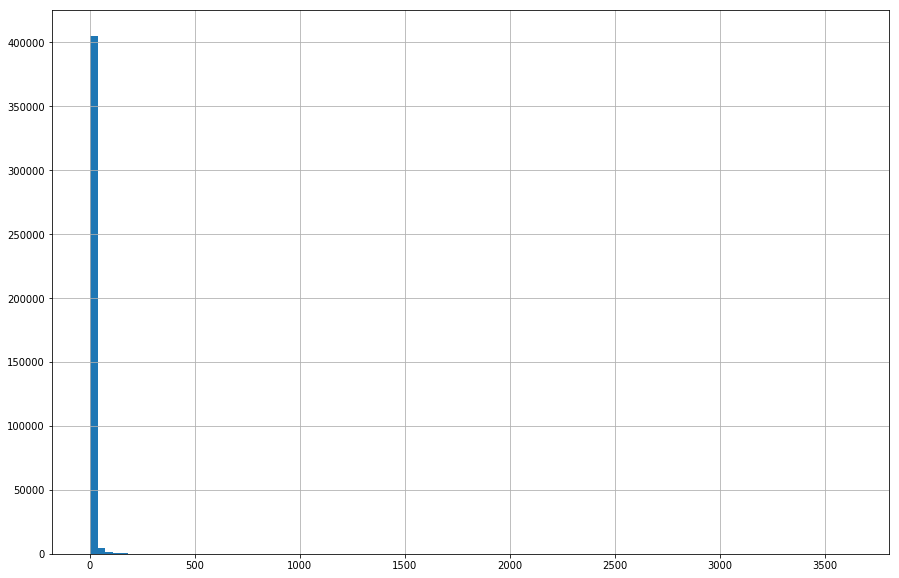

In [252]:
_, yi = data_split(ml_data)
yi.hist(bins=100, figsize=(15, 10))

Well that isn't very helpful. Let's drop all of the data that is larger than 10, and see if we can get a better look at those smaller values. They are ultimately the most important

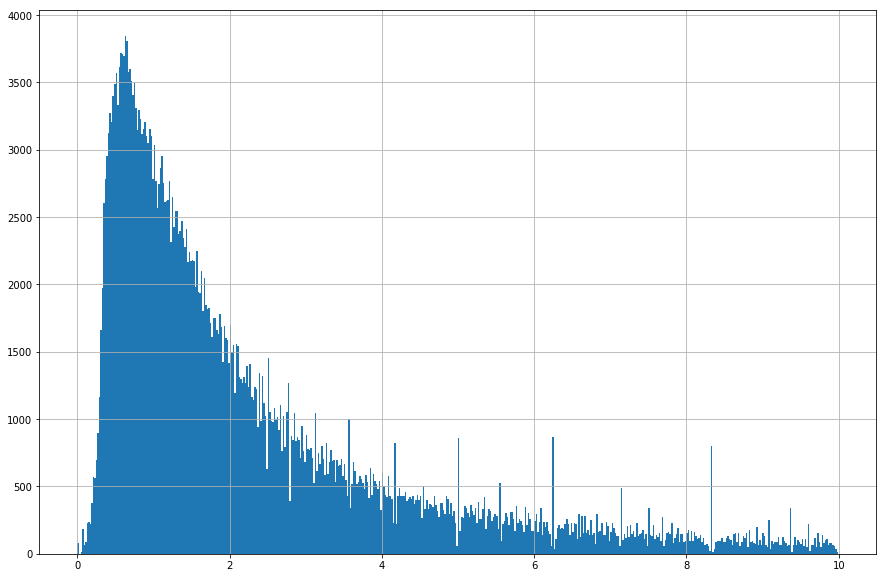

In [253]:
yi[yi < 10].hist(bins=500, figsize=(15, 10))

There aren't really any natural splits, apart from where the peak happens. Let's try to find a better value for this

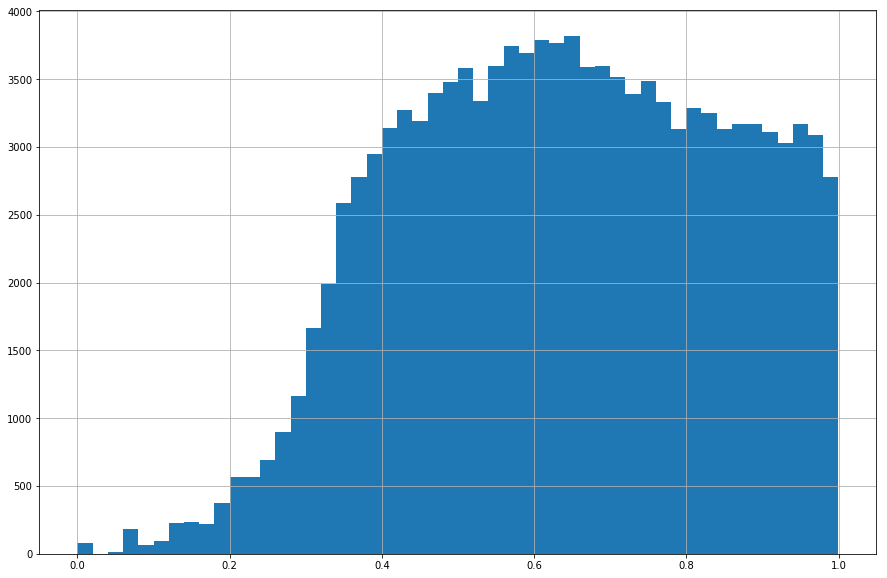

In [254]:
yi[yi < 1].hist(bins=50, figsize=(15, 10))

You can see here that the peak lies right around 0.65. Let's try a binary classifier where one bin is everything lower than 0.65

In [255]:
def bucketize(y):
    if y < 0.65:
        return 0
    return 1

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

def clf_fac():
    config = tf.contrib.learn.RunConfig(tf_random_seed=42)

    feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(Xi)
    dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[35, 15], n_classes=2, feature_columns=feature_cols, config=config)
    dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
    return dnn_clf

yi.value_counts()

1    351560
0     61259
Name: funding_velocity, dtype: int64

In [256]:
clf_preds = three_way_cv_pred(clf_fac, Xi, yi, 5_000, 500, metric='classes')

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf7e262b70>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpe5g7bujc'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpe5g7bujc/model.ckpt.
INFO:tensorflow:loss = 0.66775894, step = 1
INFO:tensorflow:global_step/sec: 7.36347
INFO:tensorflow:loss = 0.33290157, step = 101 (13.582 sec)
INFO:tensorflow:global_step/sec: 7.18754
INFO:tensorflow:loss = 0.3074401, step = 201 (13.913 sec)

In [257]:
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(yi, clf_preds))
print(accuracy_score(yi, clf_preds))

             precision    recall  f1-score   support

          0       0.54      0.14      0.22     61259
          1       0.87      0.98      0.92    351560

avg / total       0.82      0.85      0.82    412819

0.8545221998018502


While the accuracy of 0.85 is appealing, the 0.14 recall for the small bucket means that this is not very useful for what we want to do.

The next bucketing method is an arbitrary one that we tested at some point, that actually gave some decent results. It has a lot of instances in the lower bucket, which is most likely why it performs well, but at this point if it works, it works.

In [258]:
def bucketize(y):
    if y < 2:
        return 0
    if y < 15:
        return 1
    return 2

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

def clf_fac():
    config = tf.contrib.learn.RunConfig(tf_random_seed=42)

    feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(Xi)
    dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[35, 15], n_classes=3, feature_columns=feature_cols, config=config)
    dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
    return dnn_clf

yi.value_counts()

0    227241
1    161815
2     23763
Name: funding_velocity, dtype: int64

In [259]:
clf_preds = three_way_cv_pred(clf_fac, Xi, yi, 5_000, 500, metric='classes')

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbfc08d69b0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmp714bnseu'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp714bnseu/model.ckpt.
INFO:tensorflow:loss = 1.2696626, step = 1
INFO:tensorflow:global_step/sec: 7.13394
INFO:tensorflow:loss = 0.7078151, step = 101 (14.018 sec)
INFO:tensorflow:global_step/sec: 7.05745
INFO:tensorflow:loss = 0.677222, step = 201 (14.170 sec)
IN

In [260]:
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(yi, clf_preds))
print(accuracy_score(yi, clf_preds))

             precision    recall  f1-score   support

          0       0.72      0.80      0.76    227241
          1       0.61      0.58      0.59    161815
          2       0.60      0.10      0.17     23763

avg / total       0.67      0.67      0.66    412819

0.6746709817135355


This model isn't all too bad, but the main issue is that most things will be placed in the bottom class (0) simply because more classes will fall in that range no matter what. Let's see if a Random Forest fares any better using any of these bucketing methods

In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

def bucketize(y):
    if y < 0.9:
        return 0
    elif y < 1.744186:
        return 1
    elif y < 3.846154:
        return 2
    return 3

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

rf_clf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=25, n_jobs=-1)
rf_preds = cross_val_predict(rf_clf, Xi, yi)

In [262]:
from sklearn.metrics import mean_squared_error, r2_score

print(classification_report(yi, rf_preds))
print(accuracy_score(yi, rf_preds))

             precision    recall  f1-score   support

          0       0.55      0.62      0.58    103190
          1       0.39      0.37      0.38    103031
          2       0.39      0.39      0.39    103740
          3       0.62      0.58      0.60    102858

avg / total       0.49      0.49      0.49    412819

0.4905757729174287


So the random forest actually performed a good bit better than the DNN for the first bucketing method. The recall score is a little worse however so it's hard to say whether or not this would be more useful than the DNN

In [263]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

def bucketize(y):
    if y < 0.65:
        return 0
    return 1

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

rf_clf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=25, n_jobs=-1)
rf_preds = cross_val_predict(rf_clf, Xi, yi)

In [264]:
from sklearn.metrics import mean_squared_error, r2_score

print(classification_report(yi, rf_preds))
print(accuracy_score(yi, rf_preds))

             precision    recall  f1-score   support

          0       0.49      0.37      0.42     61259
          1       0.89      0.93      0.91    351560

avg / total       0.84      0.85      0.84    412819

0.8503072775235636


The accuracy here is also rather high like it was for the DNN using this bucketing method, however the recall for 0 is over twice as large, which is rather impressive.

In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

def bucketize(y):
    if y < 2:
        return 0
    if y < 15:
        return 1
    return 2

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

rf_clf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=25, n_jobs=-1)
rf_preds = cross_val_predict(rf_clf, Xi, yi)

In [266]:
from sklearn.metrics import mean_squared_error, r2_score

print(classification_report(yi, rf_preds))
print(accuracy_score(yi, rf_preds))

             precision    recall  f1-score   support

          0       0.75      0.79      0.77    227241
          1       0.62      0.63      0.62    161815
          2       0.47      0.19      0.27     23763

avg / total       0.68      0.69      0.68    412819

0.6924414816178519


As with the firt bucketing method, the accuracy is higher, but the recall for 0 is slightly lower, so they are roughly as good as each other.

So trying to predict low didn't work all too well, so we wondered if it would be possible to predict loans that would have a higher funding velocity. In theory, these loans would get more views, so maybe Kiva could advertise loans that haven't been funded very much on those other loans in an attempt to balance out the funding.

Let's place the cutoff at the 90th quantile.

In [267]:
_, yi = data_split(ml_data)
yi.quantile(0.9)

9.090909090909092

In [268]:
def bucketize(y):
    if y < 9.1:
        return 0
    return 1

ss = StandardScaler()
Xi, yi = data_split(ml_data)
Xi = ss.fit_transform(Xi)
yi = yi.apply(bucketize)

def clf_fac():
    config = tf.contrib.learn.RunConfig(tf_random_seed=42)

    feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(Xi)
    dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[35, 15], n_classes=2, feature_columns=feature_cols, config=config)
    dnn_clf = tf.contrib.learn.SKCompat(dnn_clf)
    return dnn_clf

yi.value_counts()

0    371589
1     41230
Name: funding_velocity, dtype: int64

In [269]:
clf_preds = three_way_cv_pred(clf_fac, Xi, yi, 5_000, 500, metric='classes')

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbfb49bf128>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': 42, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpvd3p_swj'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpvd3p_swj/model.ckpt.
INFO:tensorflow:loss = 0.7795759, step = 1
INFO:tensorflow:global_step/sec: 7.48883
INFO:tensorflow:loss = 0.26916635, step = 101 (13.355 sec)
INFO:tensorflow:global_step/sec: 7.45371
INFO:tensorflow:loss = 0.2598752, step = 201 (13.416 sec)


In [270]:
from sklearn.metrics import accuracy_score, classification_report

print(classification_report(yi, clf_preds))
print(accuracy_score(yi, clf_preds))

             precision    recall  f1-score   support

          0       0.92      0.99      0.95    371589
          1       0.64      0.21      0.32     41230

avg / total       0.89      0.91      0.89    412819

0.9090497288157764


Although this is by far the highest precision, considering we but the cutoff at 90%, and that the accuracy is only slightly over 90%, it means that this classifier isn't very good. That can be really seen in the recall score for 1.

# Conclusions

Although these results might not seem to give us much to work with, there is something rather important that we (and we believe Kiva as well) can learn from testing out these models: people just don't fund loans in a predictable way. We can go even further than this and look at what features we have in our data, because the results of training models means that the features provided aren't good predicters of the label. In this case we had quite a few metrics involving the MPI for the region and the nation the loan came from, and yet it wasn't enough to get a really good model. This means that not only are loans funded inpredictably, but that people in general aren't very good at funding the loans from regions where the people are more poor. Although it isn't clear why Kiva wants to estimate the welfare level of their borrowers, since they don't really have a ton of control over their lenders, a good welfare metric would be worth providing to people so that they can make more informed decisions about who they lend their money to. If Kiva are to get anything from our project, we believe that this is one of the most important conclusions, since it gives Kiva information they might not have known about the general body of their lenders.

Another interesting result from this project is the fact that the average funding velocity increases as the size of the loan increases, almost linearly in fact. Whether or not this is an issue is out of the scope of our skillset, however we believe that it is indicative that people get overwhelmed when it comes to choosing which loan to participate in. Looking at the distribution of loan sizes, you can see that there are a ton at the lower end of the spectrum. This means that if someone were new to Kiva they might get daunted at choosing between some of the smaller loans, and then end up funding one of the larger loans because they might believe that because it is larger (such as one of the \$50,000 loans), it will end up helping more people. What we propose that Kiva could do in order to help balance this imbalance (again, if Kiva actually label this as an issue), is creating a sort of "Kiva fund" on their site that would allow lenders to lend to it rather than a specific loan. Then, Kiva can take that money and put it towards a loan that they believe needs the money more. This could be done using some sort of algorithm (or even Machine Learning), by experts that could take a look and sort through loans and determine their 'neediness', or better yet, a combination of both.

A small, yet significant outcome of one of the visualizations is that loans are funded faster when they are posted during the holidays in the winter. Although Kiva might have already known this in the form of internet traffic, they can now know that on average, a particular loan gets funded around 9 dollars per hour in december, and 16 dollars per hour in January. For the majority of the other months however, this number is around 3 dollars an hour. We thought these were rather staggering numbers, and that it might be very helpful for those in need to put some effort into advertising or spreading the word about Kiva during their down months so that those who need the money during those months get it as fast as possible.

Although we decided not to use any machine learning to try and predict certain features like whether a loan will be fully funded or not or the percentage of the loan amount that was funded, we would definitely tackle this, since this would be equally as helpful as a good model to predict the funding velocity of a loan. If we could tell Kiva with a good ammount of accuracy whether or not a loan will be fully funded, it could modify the way that it displays loans in order for those loans to get more views by the lenders. We had some issues getting the Neural Networks setup (mostly due to inexperience), so we weren't able to get multi label calssification working as we initially intended, and some of the training took so long that we ended up not having the time to actually train some models to just predict `fully_funded`. Most of our time went into getting the dataset into the best possible format for machine learning and trying to just understand the data as best as we could, that it left us with very little time to test out different models and test different hypterparameters. The one great thing however is that if someone were to want to try and augment our work, they would already have the ability to get the data into a nice format for machine learning. That even includes us, if after this project, one of us wants to continue working on this data in hopes of getting better results.

With the work we did on the dataset, it also wouldn't be very difficult to find other datasets with better features for predicting the PPI, which could definitely help. We decided not to spend too much time looking for more data, since we wanted to challenge ourselves to mostly using provided data, since it would be the easiest to implement within Kiva's infrastructure. They already have all of the data they gave us, so all they would need to do is slap in our algorithm and get to back to day-to-day operations, but it really looks as if the data they have is just not enough.

Overall, although we were not able to present Kiva with a magic neural network to solve all their problems, we believe that there are many insights to be gained as a result of our work on this project. Even if we don't come close to being the best kernel, we hope that our work will somehow benefit someone, whether through Kiva or the other participants in this competition. The goal after all is not to win, but to use Data Science for Good.